<a href="https://colab.research.google.com/github/SifenTesfa/Solution/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import csv
import numpy as np
from typing import Set,Tuple, List
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torchvision
NoneType = type(None)
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models import vgg11
from torchvision.models import mobilenet_v2
import torchvision.transforms as transforms
import time

In [41]:
def id_to_fruit(fruit_id, fruits):
    """Returns the fruit name by getting the string at a specific index"""
    # Convert the set to a sorted list to ensure a fixed order
    fruit_list = sorted(fruits)

    if fruit_id < 0 or fruit_id >= len(fruit_list):
        raise RuntimeError(f"Fruit with id {fruit_id} does not exist")

    return fruit_list[fruit_id]

# Define fruits as a list (ensuring order)
fruits_list = ["apple", "orange", "melon", "kiwi", "strawberry"]

name1 = id_to_fruit(1, fruits_list)  # Expected: 'orange'
name3 = id_to_fruit(3, fruits_list)  # Expected: 'kiwi'
name4 = id_to_fruit(4, fruits_list)  # Expected: 'strawberry'

print(name1)
print(name3)
print(name4)


kiwi
orange
strawberry


In [42]:
import numpy as np

def swap(coords: np.ndarray):
    """
    This method flips the x and y coordinates in the coords array.
    """
    swapped_coords = coords.copy()  # Create a copy to avoid modifying the original array
    swapped_coords[:, [0, 1, 2, 3]] = swapped_coords[:, [1, 0, 3, 2]]  # Swap x and y coordinates
    return swapped_coords

# Sample test case
coords = np.array([[10, 5, 15, 6, 0],
                   [11, 3, 13, 6, 0],
                   [5, 3, 13, 6, 1],
                   [4, 4, 13, 6, 1],
                   [6, 5, 13, 16, 1]])

swapped_coords = swap(coords)
print(swapped_coords)


[[ 5 10  6 15  0]
 [ 3 11  6 13  0]
 [ 3  5  6 13  1]
 [ 4  4  6 13  1]
 [ 5  6 16 13  1]]


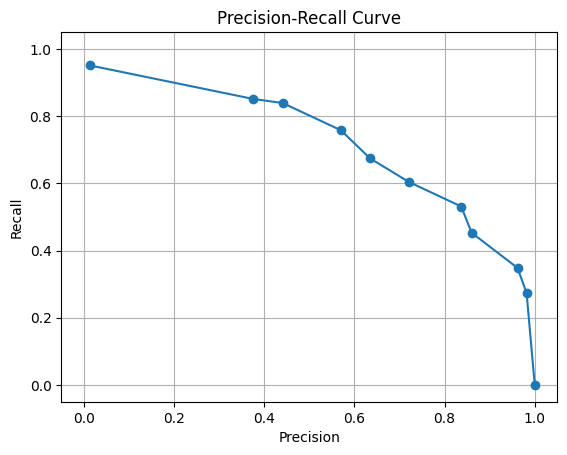

In [43]:
import csv
import numpy as np
import matplotlib.pyplot as plt

def plot_data(csv_file_path: str):
    """
    Plots the precision-recall curve based on a CSV file.
    Fixes issues related to incorrect data types and incorrect axis plotting.
    """
    results = []
    with open(csv_file_path) as result_csv:
        csv_reader = csv.reader(result_csv, delimiter=',')
        next(csv_reader)  # Skip header
        for row in csv_reader:
            results.append([float(row[0]), float(row[1])])  # Convert to float

    results = np.array(results)  # Convert list to NumPy array

    # Plot precision-recall curve
    plt.plot(results[:, 0], results[:, 1], marker="o", linestyle="-")  # Fix axis order
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.xlabel('Precision')  # Correct label
    plt.ylabel('Recall')     # Correct label
    plt.title('Precision-Recall Curve')  # Add title
    plt.grid(True)  # Improve readability
    plt.show()

# Creating CSV file for testing
f = open("data_file.csv", "w")
w = csv.writer(f)
_ = w.writerow(["precision", "recall"])
w.writerows([[0.013, 0.951],
             [0.376, 0.851],
             [0.441, 0.839],
             [0.570, 0.758],
             [0.635, 0.674],
             [0.721, 0.604],
             [0.837, 0.531],
             [0.860, 0.453],
             [0.962, 0.348],
             [0.982, 0.273],
             [1.0, 0.0]])
f.close()

# Plot data
plot_data('data_file.csv')


In [44]:
# You can copy this code to your personal pipeline project or execute it here.
class Generator(nn.Module):
    """
    Generator class for the GAN
    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



In [45]:
# You can copy this code to your personal pipeline project or execute it here.
class Discriminator(nn.Module):
    """
    Discriminator class for the GAN
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output



In [46]:
def train_gan(batch_size: int = 32, num_epochs: int = 100, device: str = "cuda:0" if torch.cuda.is_available() else "cpu"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    try:
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
    except:
        print("Failed to download MNIST, retrying with different URL")
        torchvision.datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # Set up models
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)

    # Adjusted learning rate for better training
    lr = 0.0002
    loss_function = nn.BCELoss()
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Train
    for epoch in range(num_epochs):
        for n, (real_samples, _) in enumerate(train_loader):

            # Dynamically get batch size
            real_batch_size = real_samples.size(0)

            # Flatten input for Discriminator
            real_samples = real_samples.view(real_batch_size, 784).to(device)
            real_samples_labels = torch.ones((real_batch_size, 1)).to(device)

            # Generate fake samples
            latent_space_samples = torch.randn((real_batch_size, 100)).to(device)
            generated_samples = generator(latent_space_samples)
            generated_samples = generated_samples.view(real_batch_size, 784).to(device)
            generated_samples_labels = torch.zeros((real_batch_size, 1)).to(device)

            # Combine real and fake data
            all_samples = torch.cat((real_samples, generated_samples), dim=0)
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

            # Train Discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

            # Train Generator
            generator.zero_grad()
            latent_space_samples = torch.randn((real_batch_size, 100)).to(device)
            generated_samples = generator(latent_space_samples)
            generated_samples = generated_samples.view(real_batch_size, 784).to(device)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()

            # Display images every 100 batches
            if n % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{n}/{len(train_loader)}], Loss D: {loss_discriminator:.4f}, Loss G: {loss_generator:.4f}")

                generated_samples = generated_samples.detach().cpu().numpy()
                fig = plt.figure()
                for i in range(16):
                    sub = fig.add_subplot(4, 4, 1 + i)
                    sub.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
                    sub.axis('off')
                fig.suptitle(f"Generated Images - Epoch {epoch+1}")
                fig.tight_layout()
                clear_output(wait=True)
                display(fig)


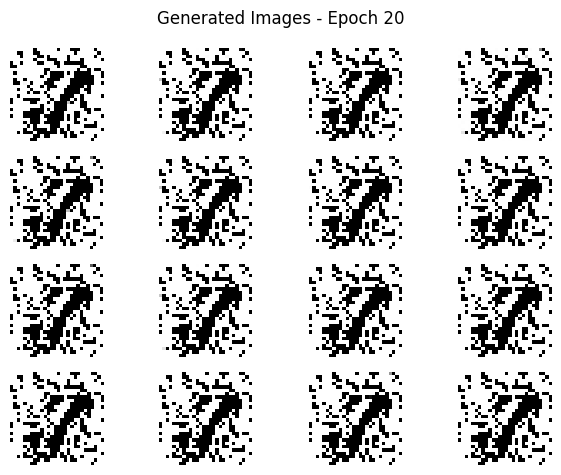

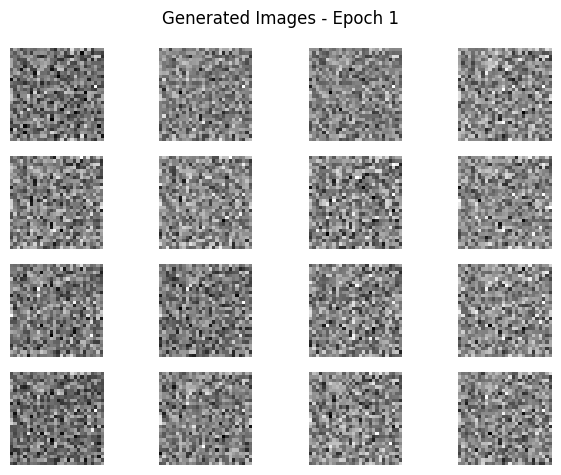

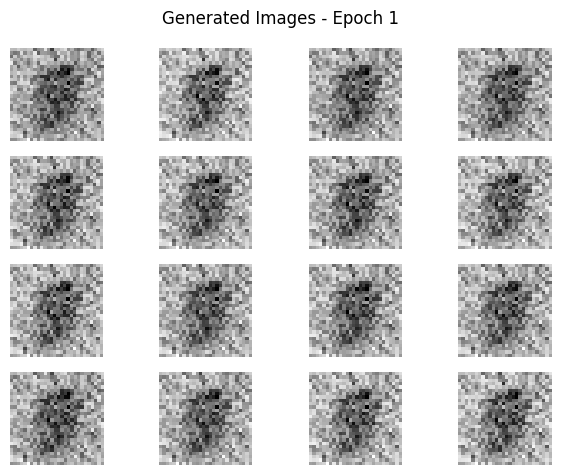

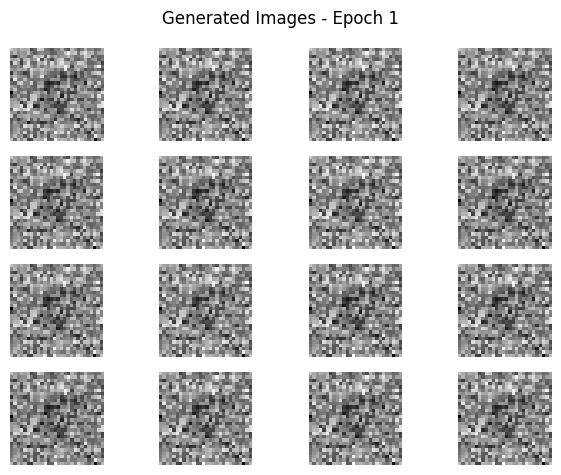

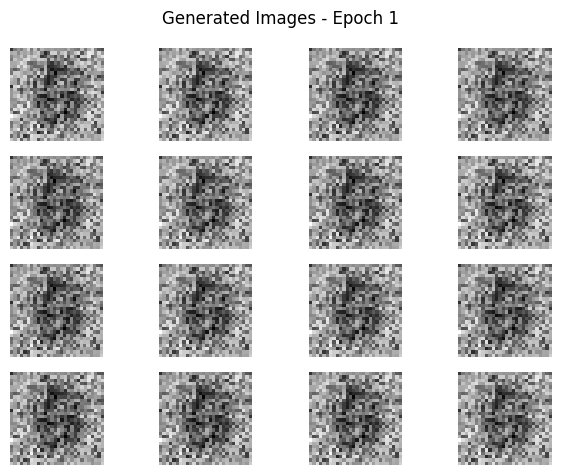

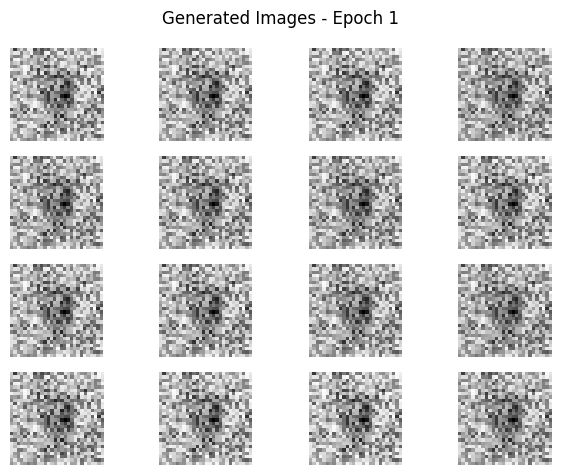

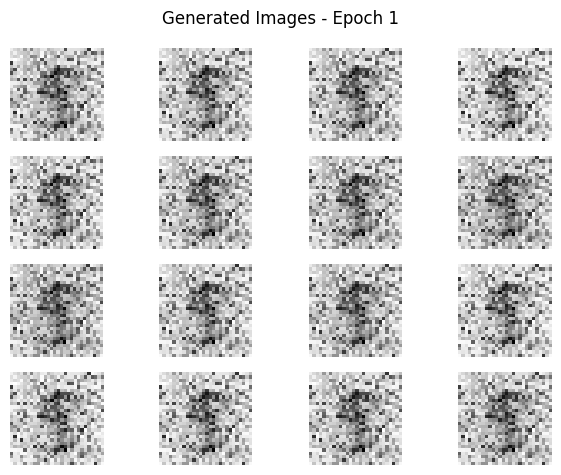

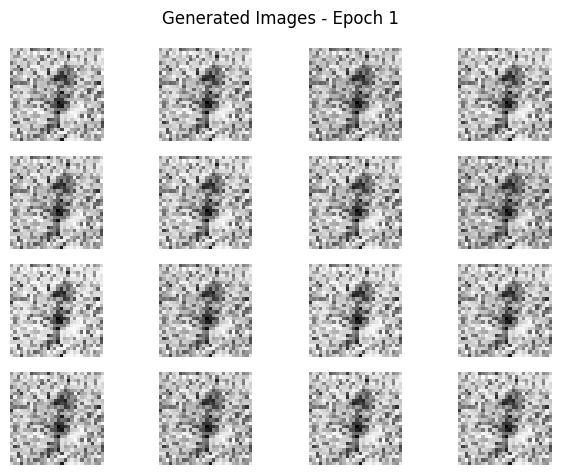

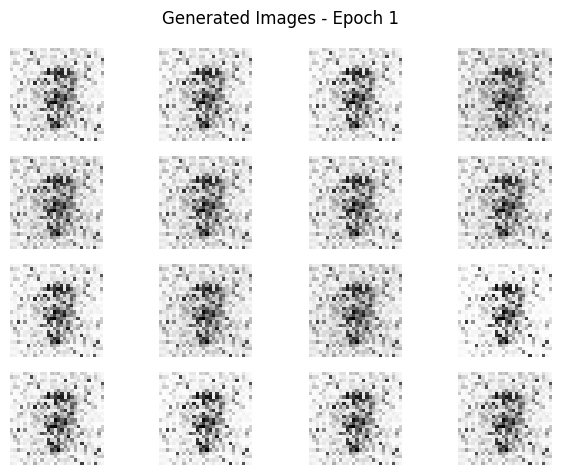

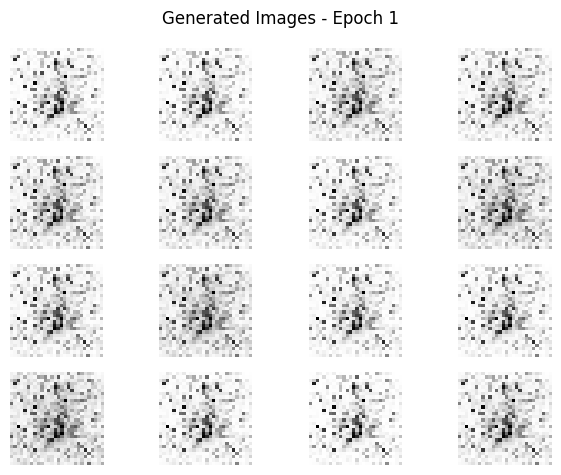

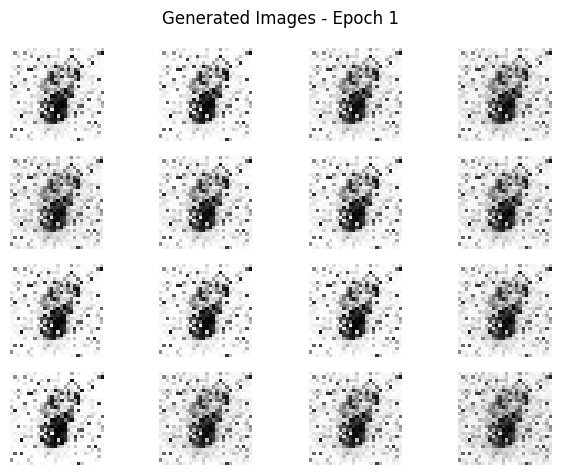

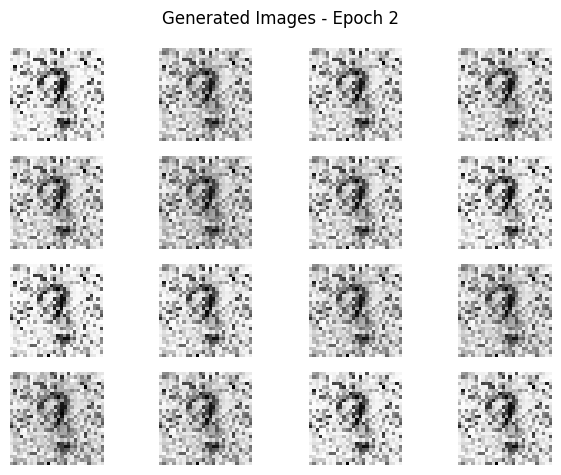

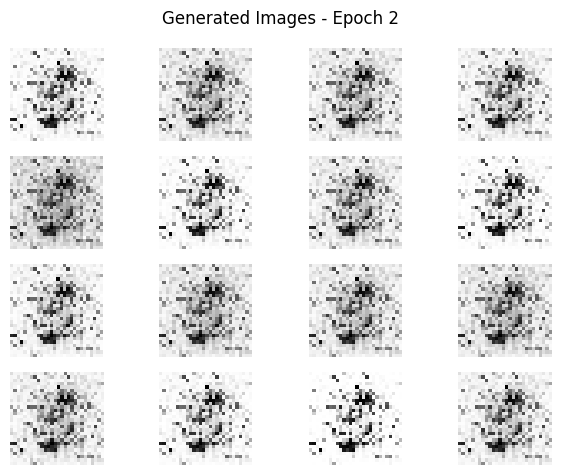

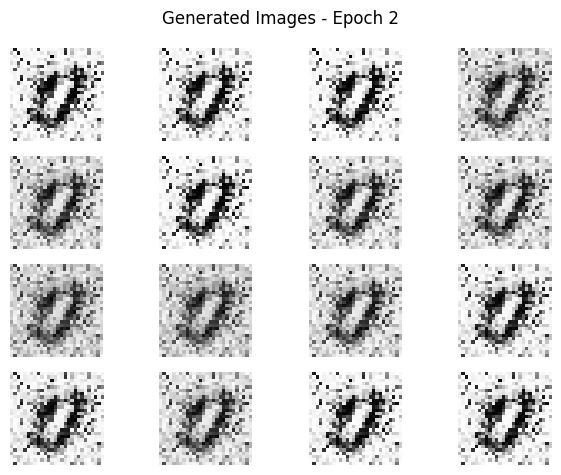

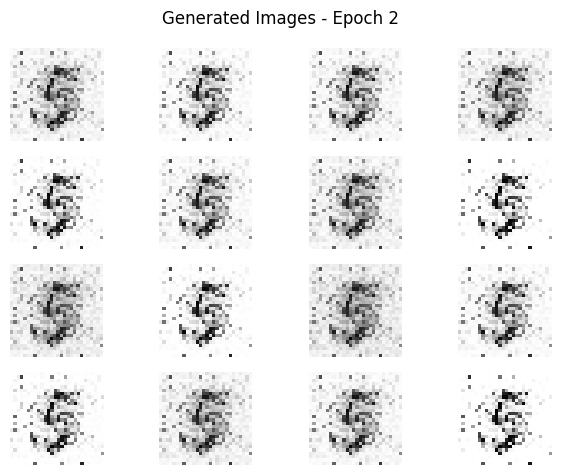

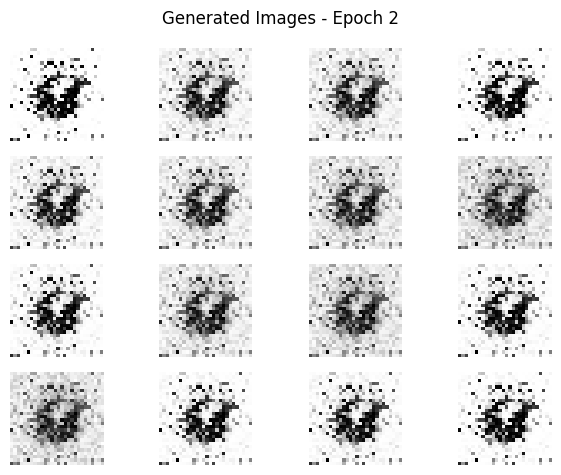

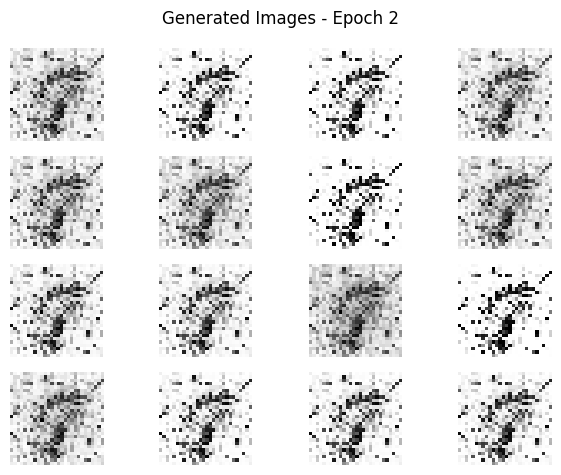

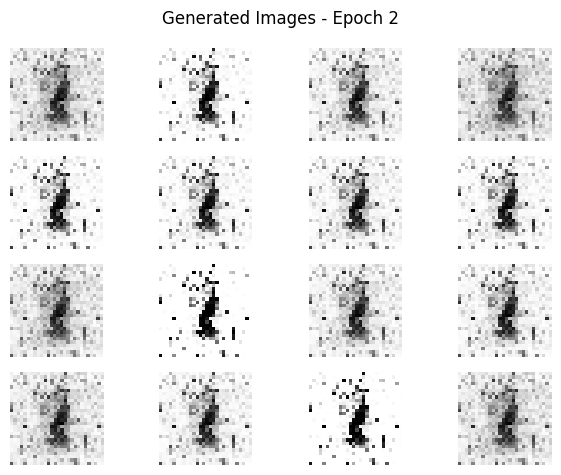

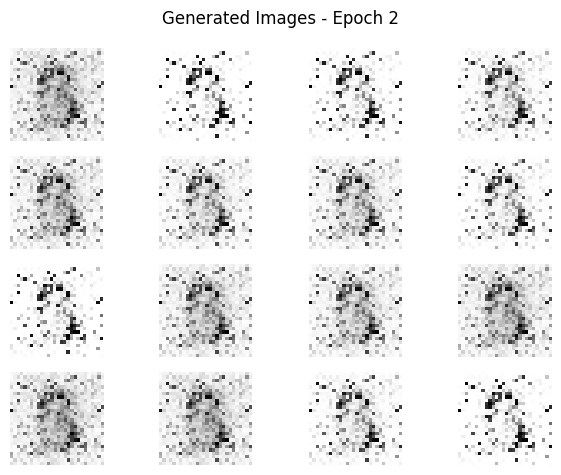

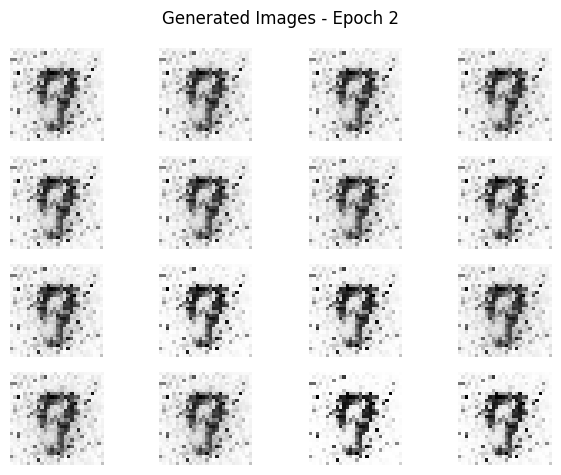

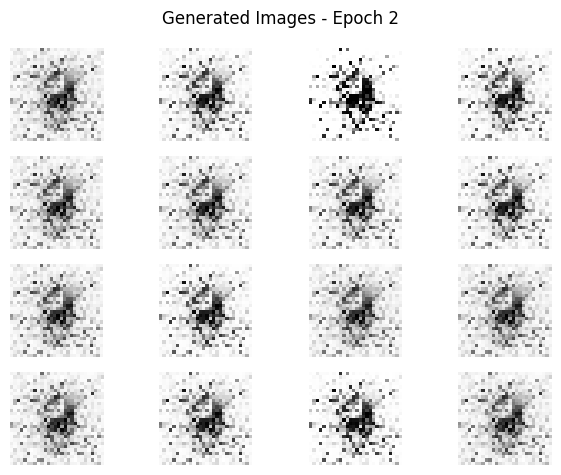

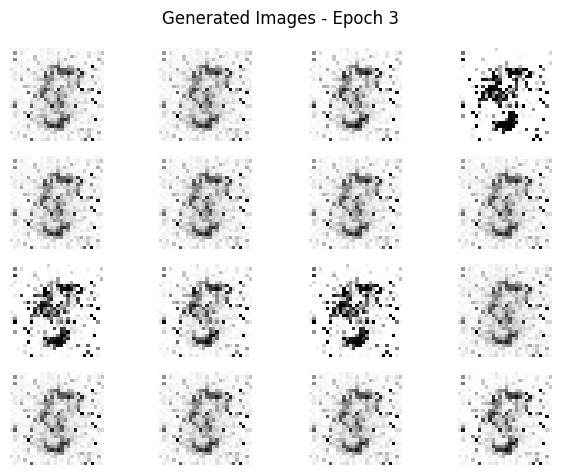

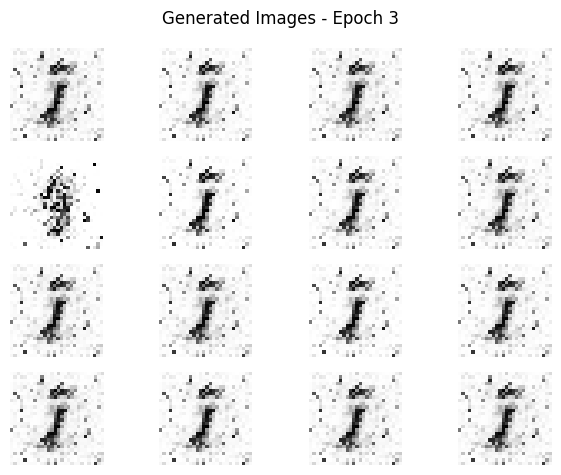

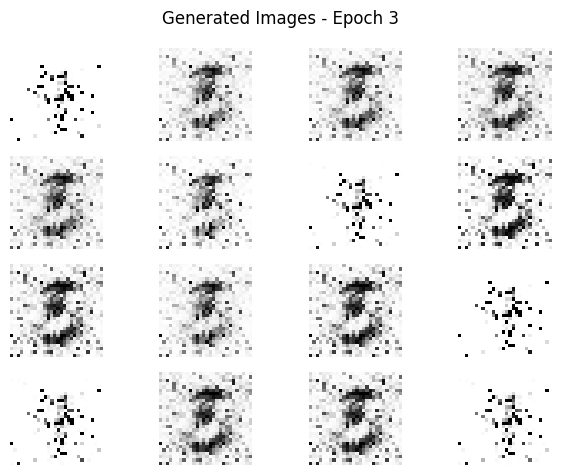

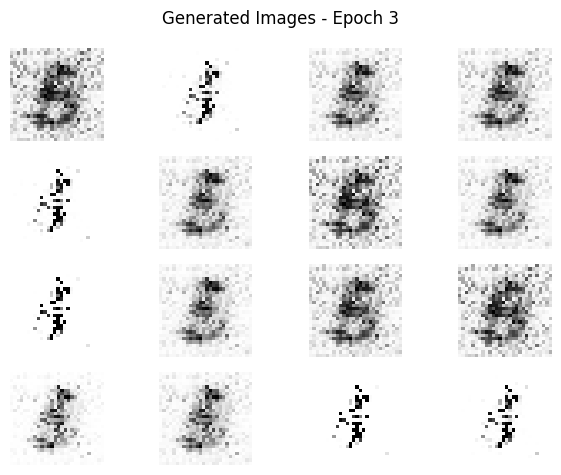

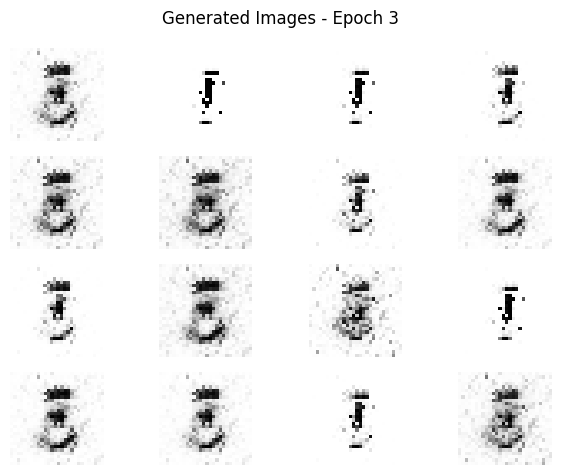

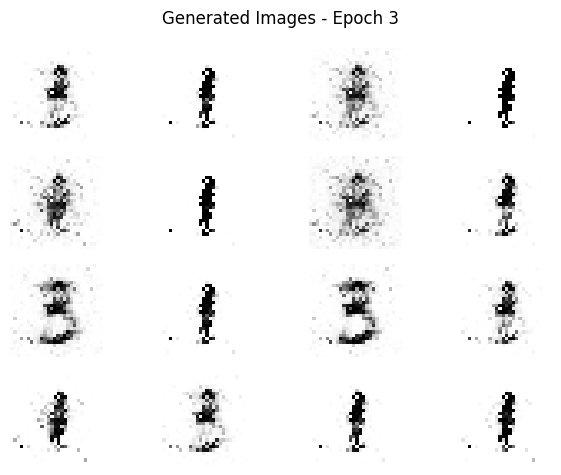

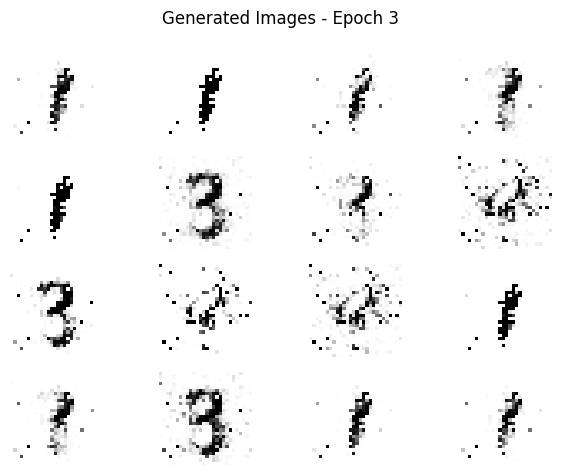

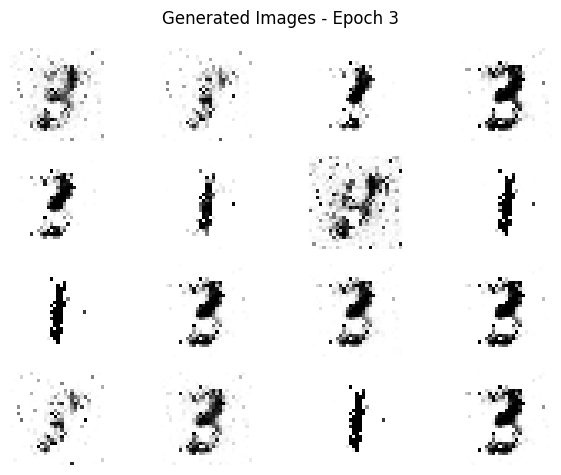

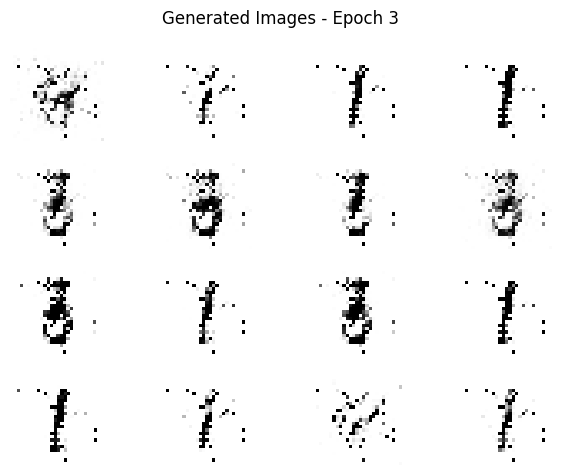

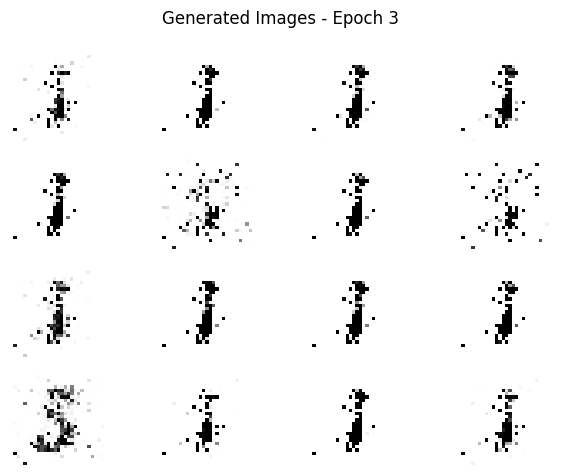

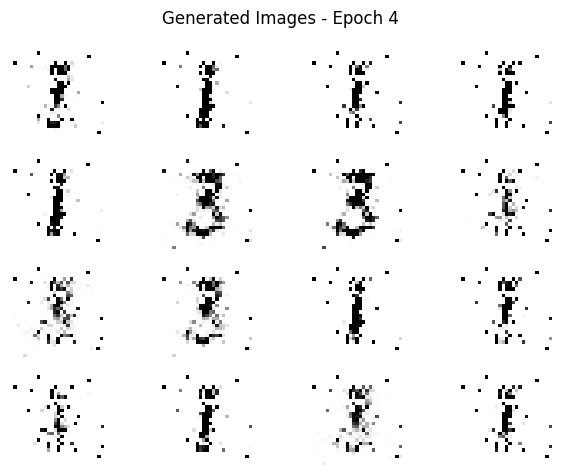

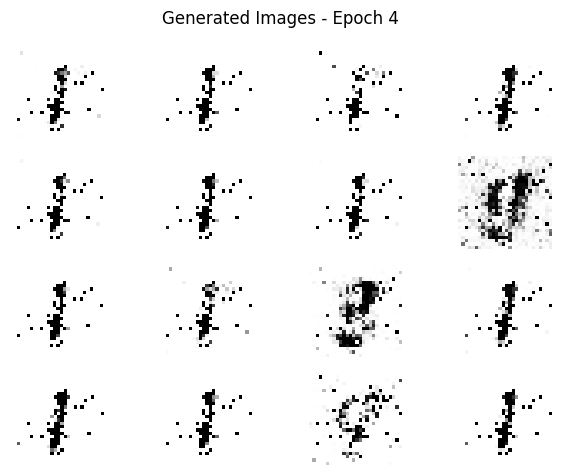

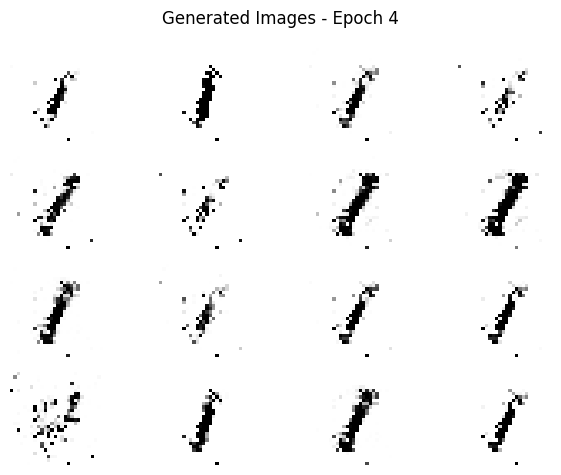

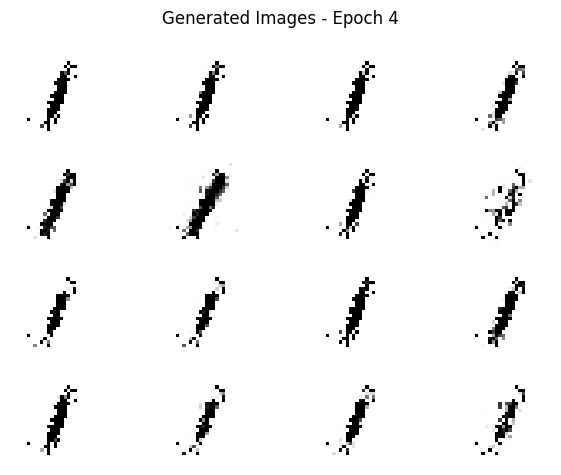

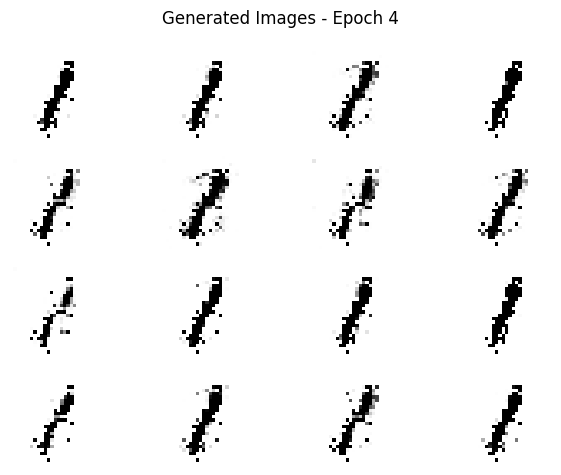

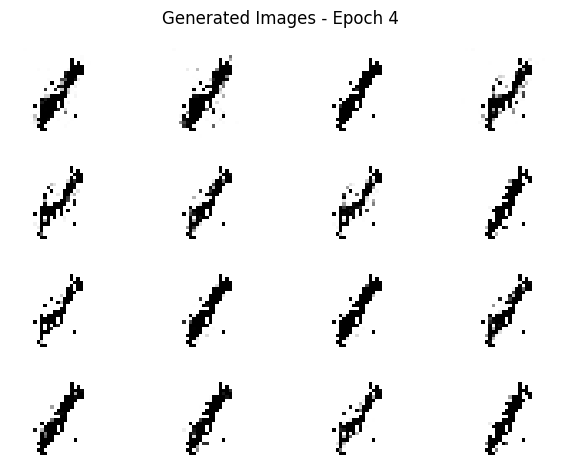

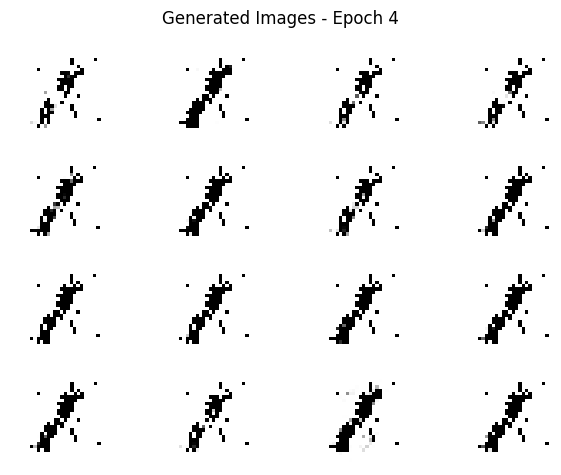

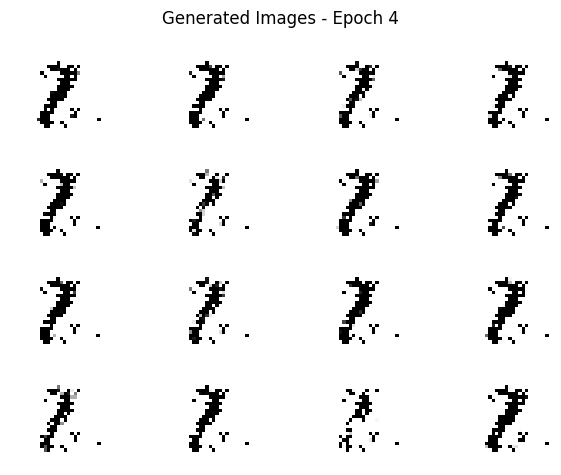

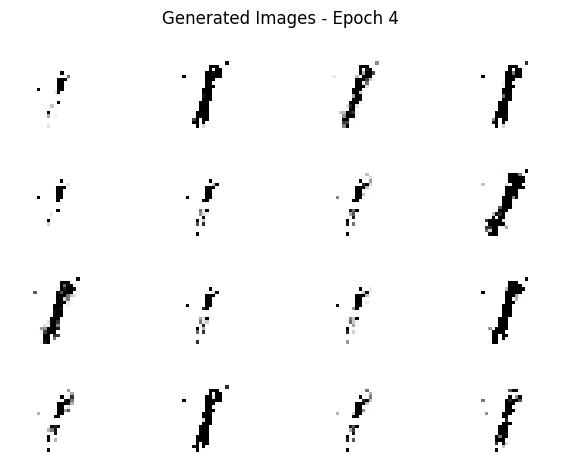

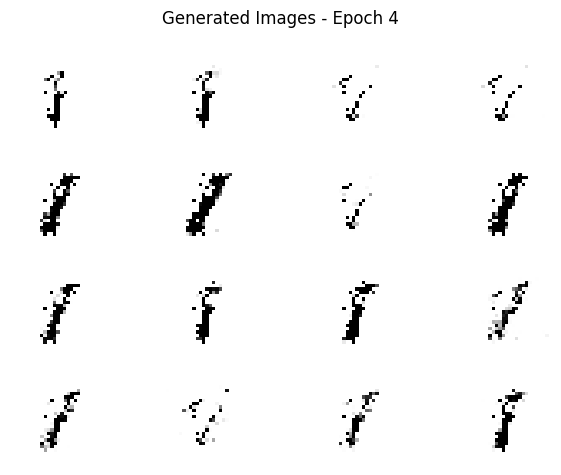

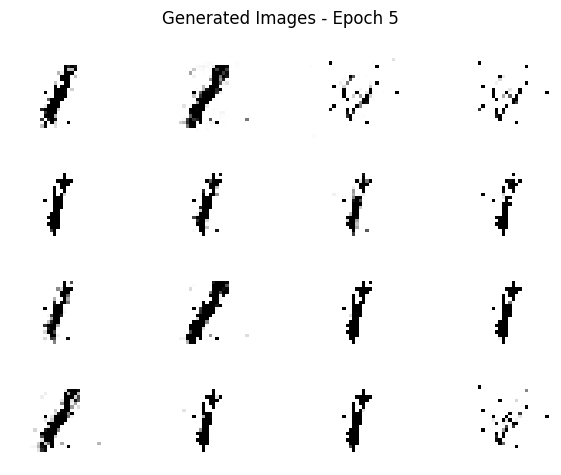

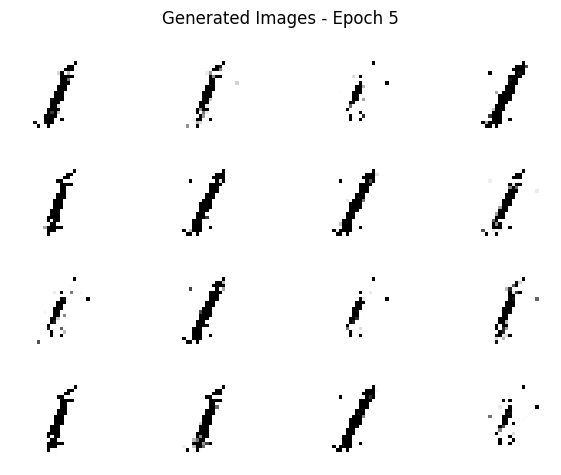

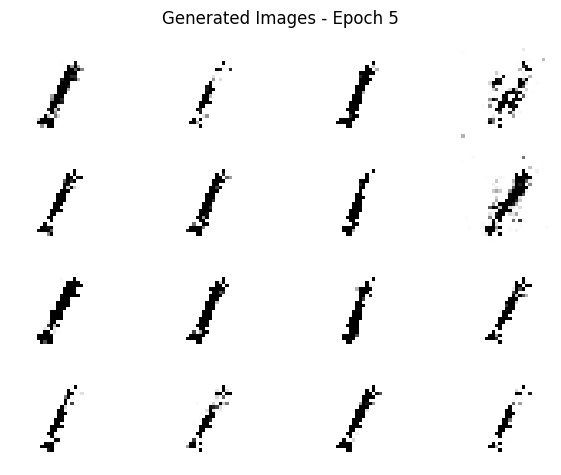

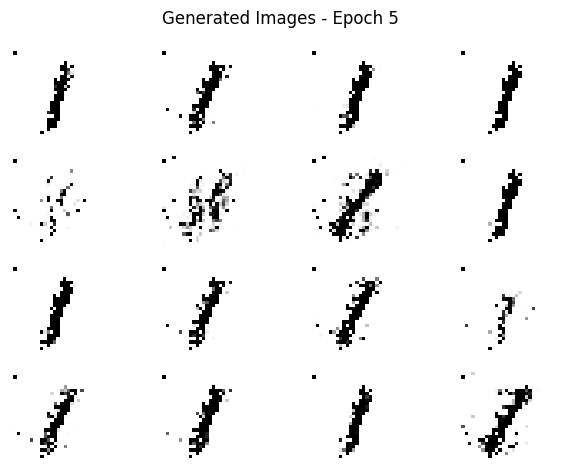

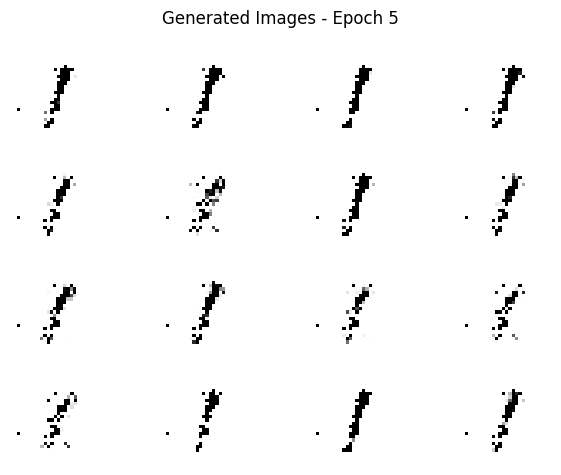

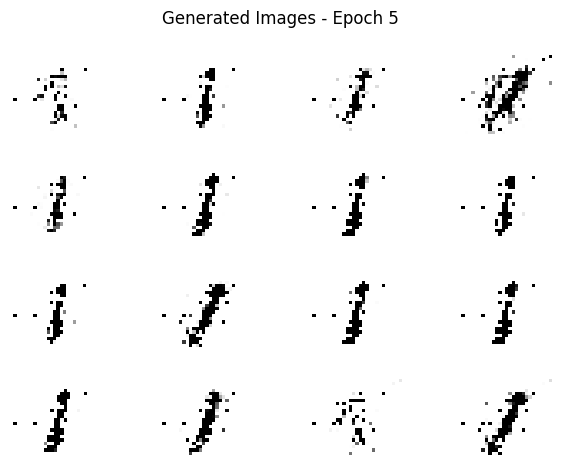

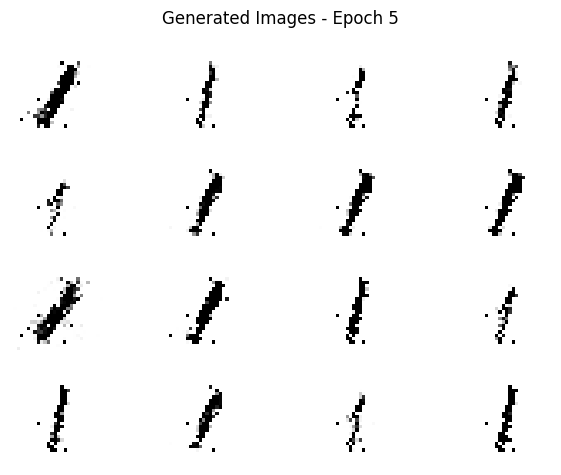

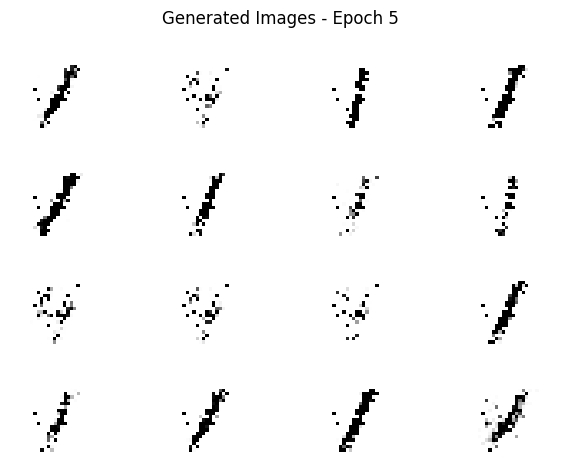

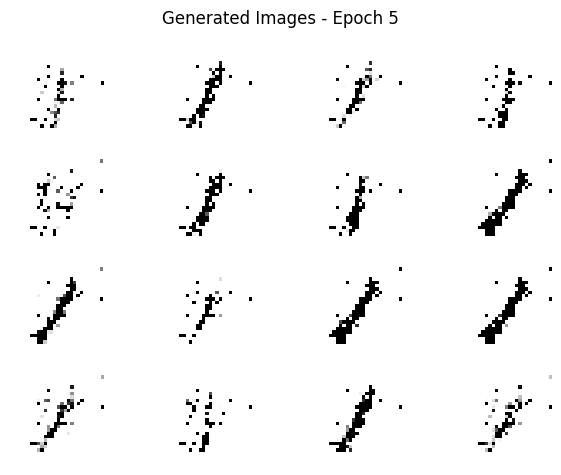

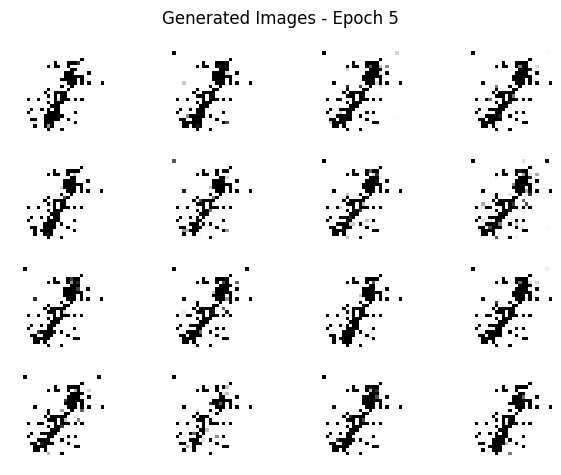

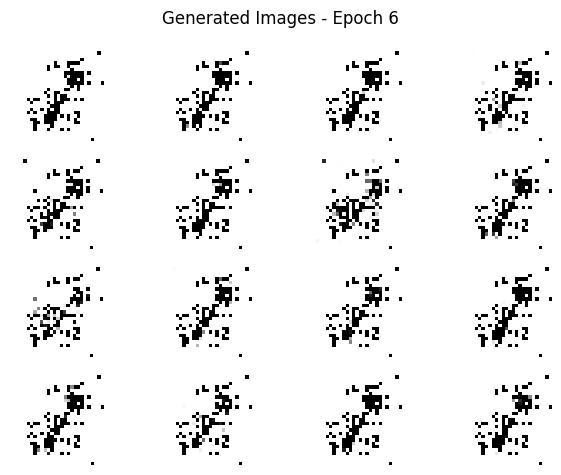

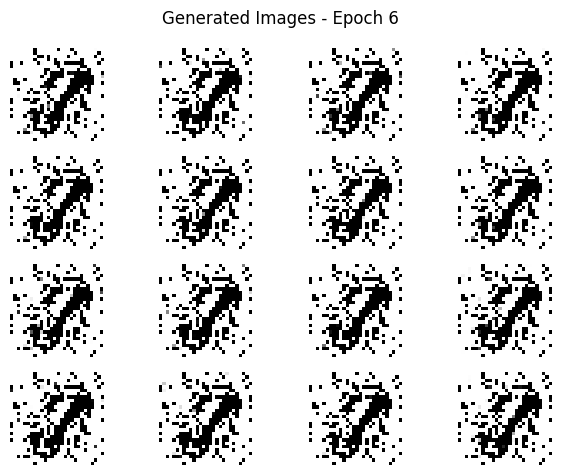

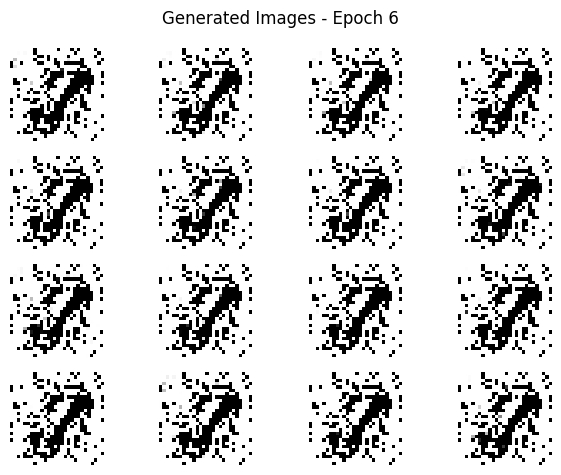

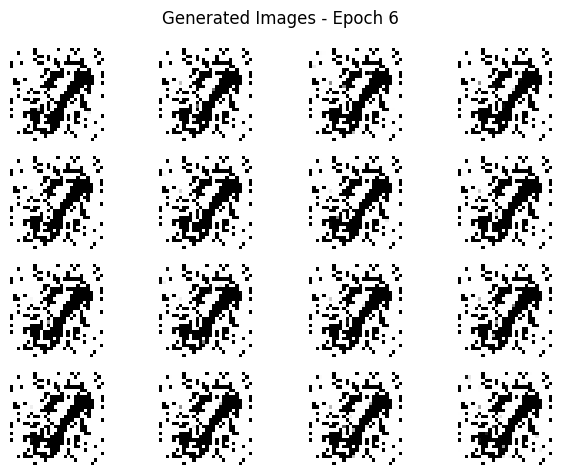

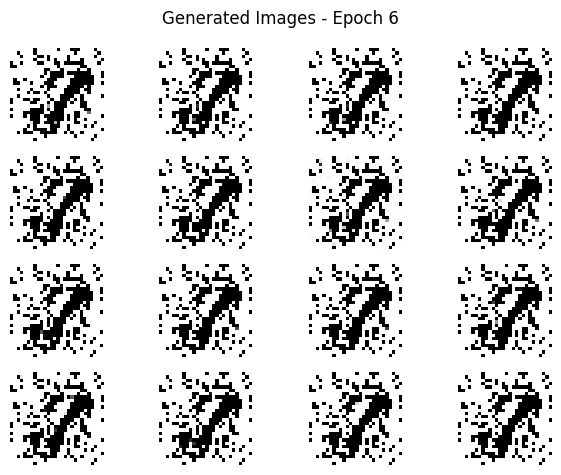

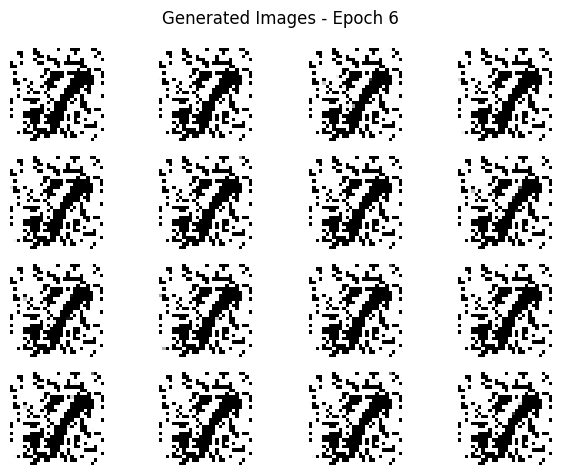

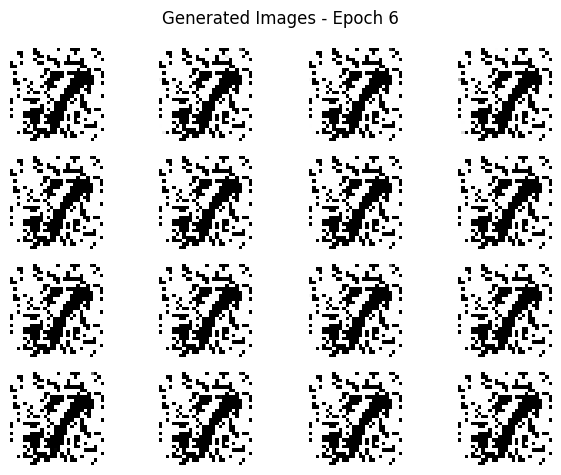

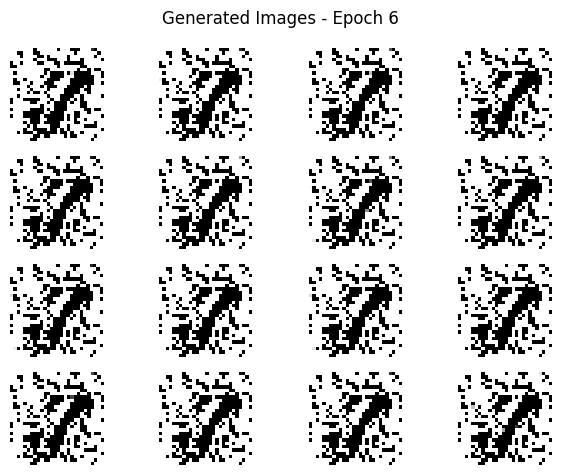

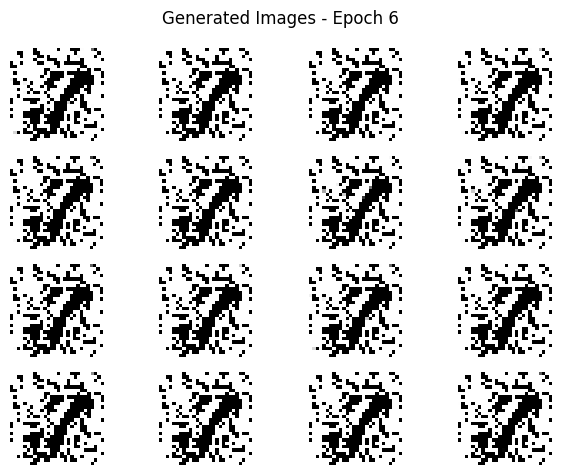

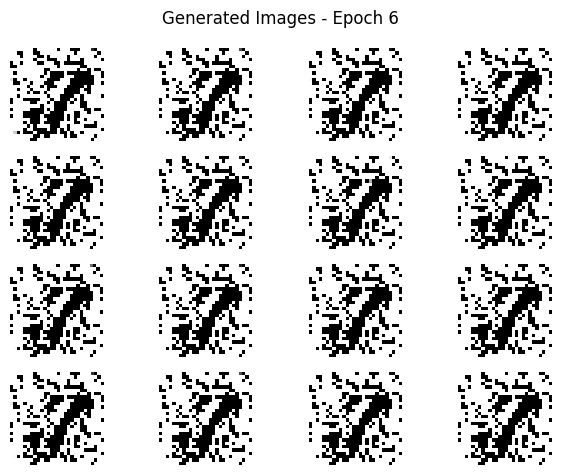

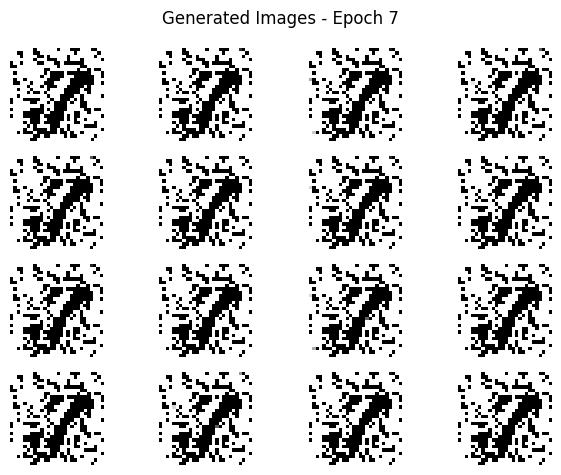

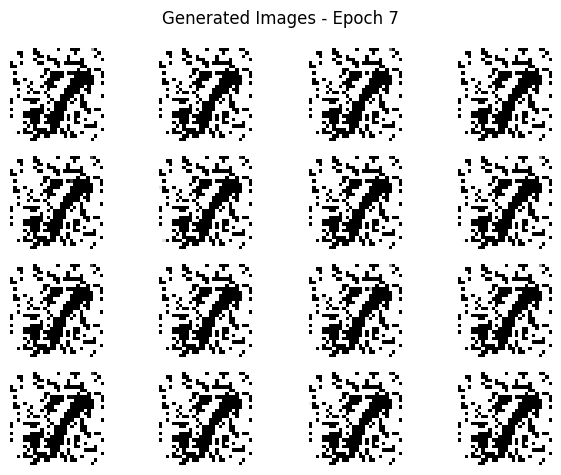

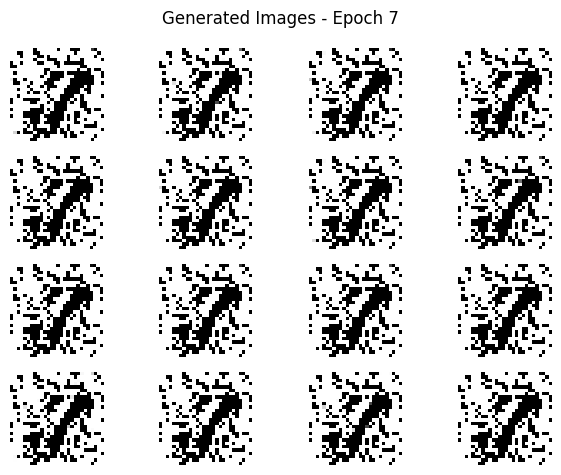

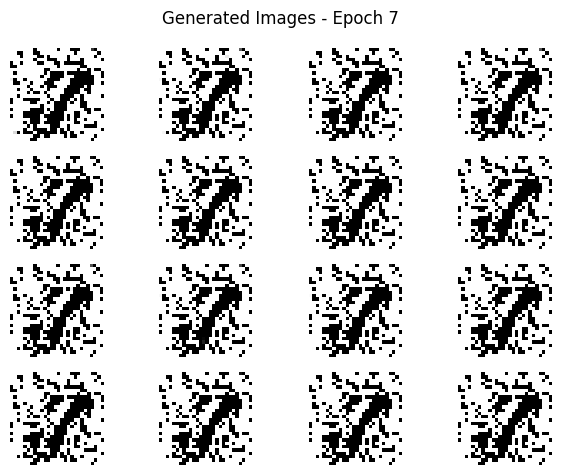

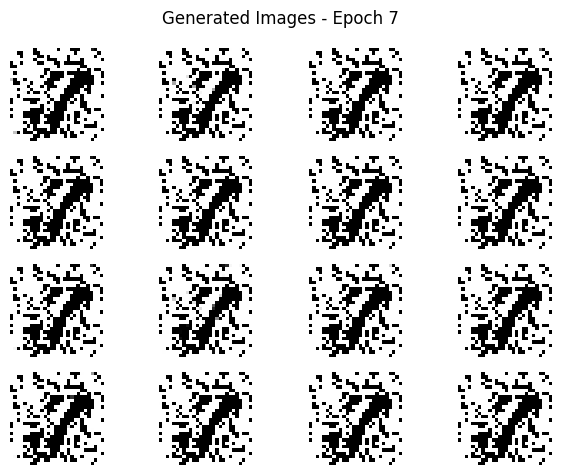

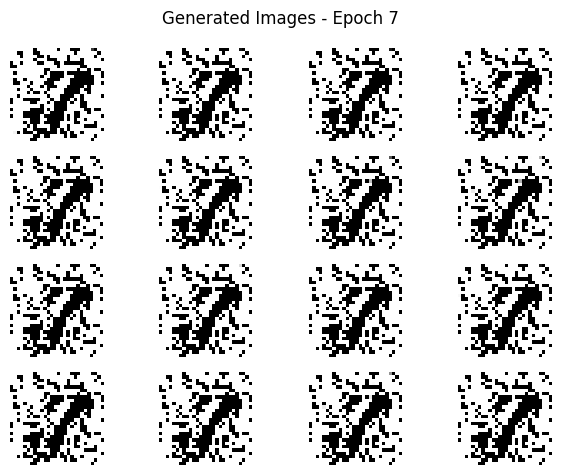

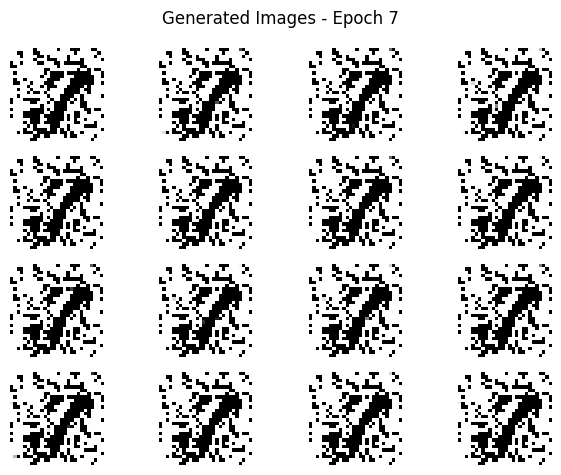

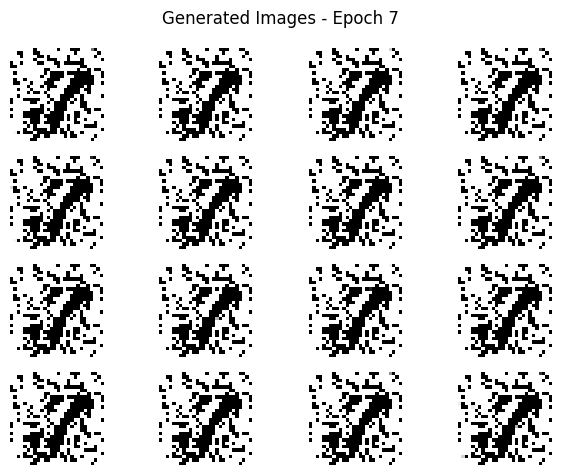

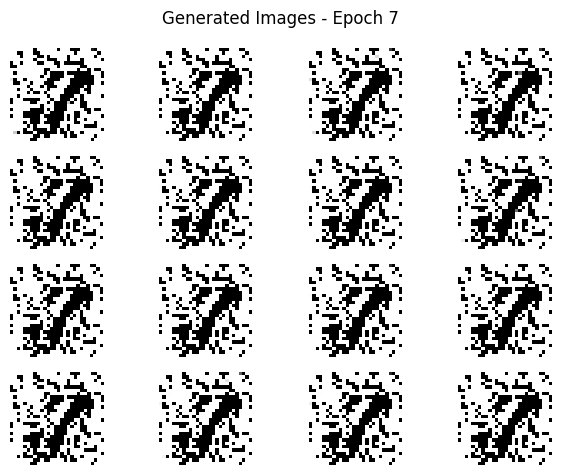

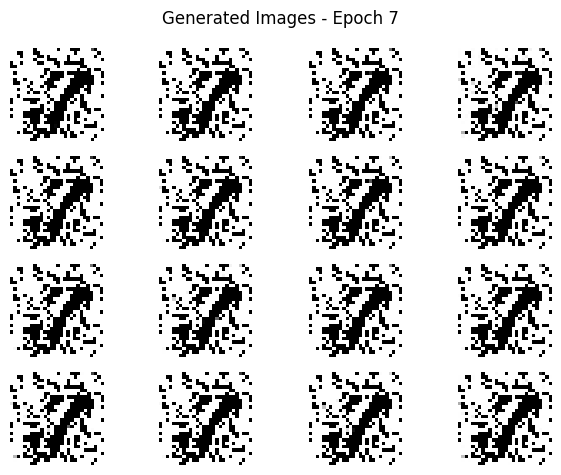

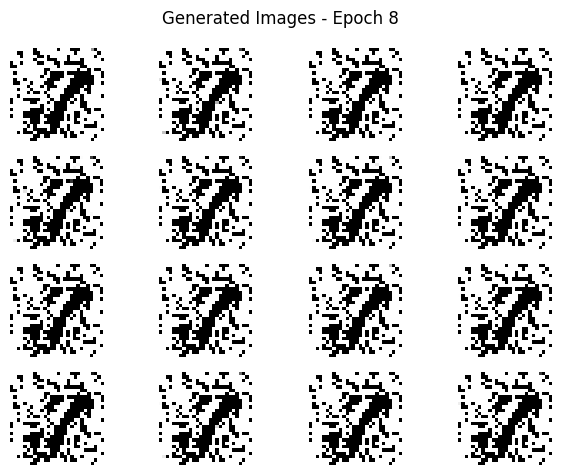

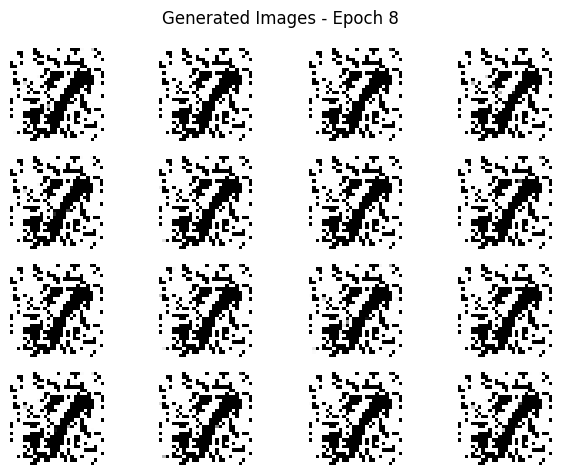

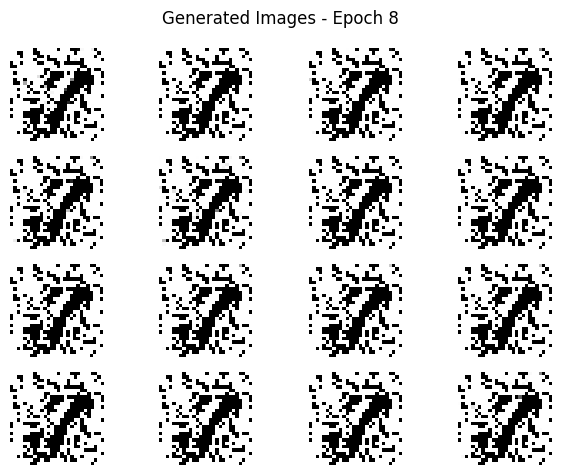

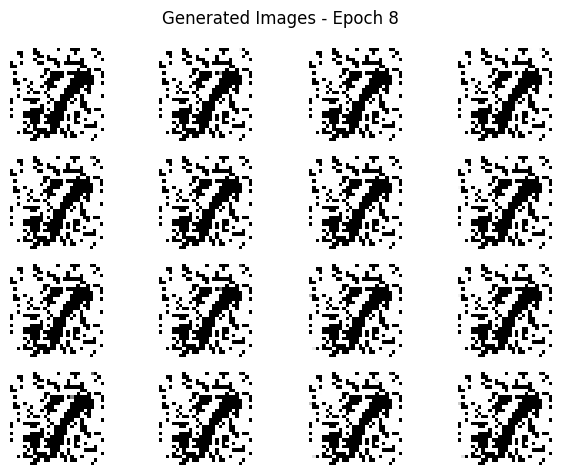

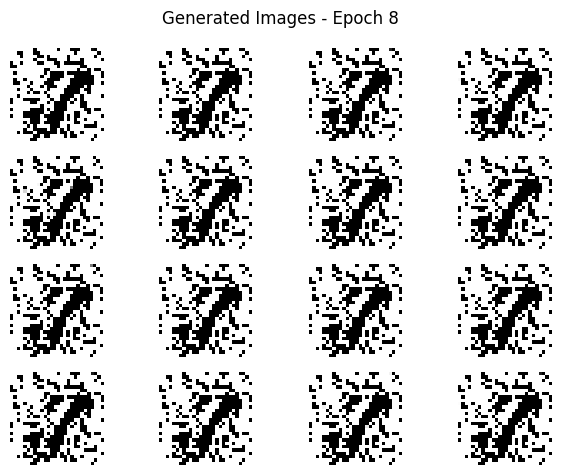

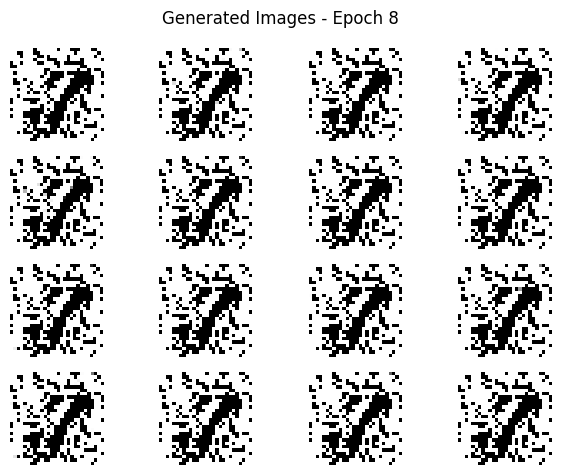

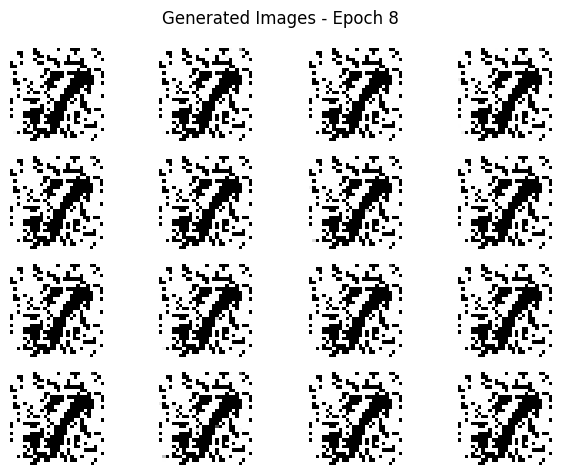

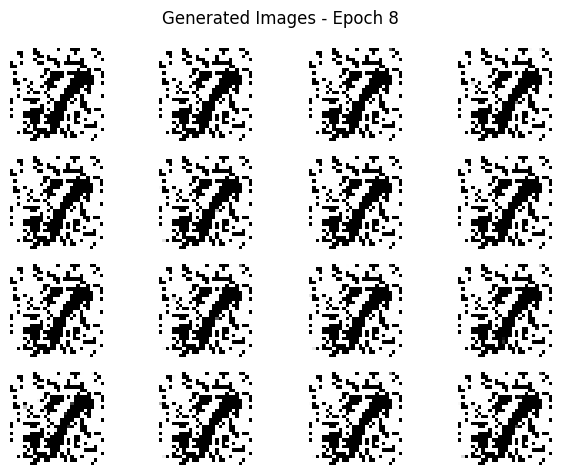

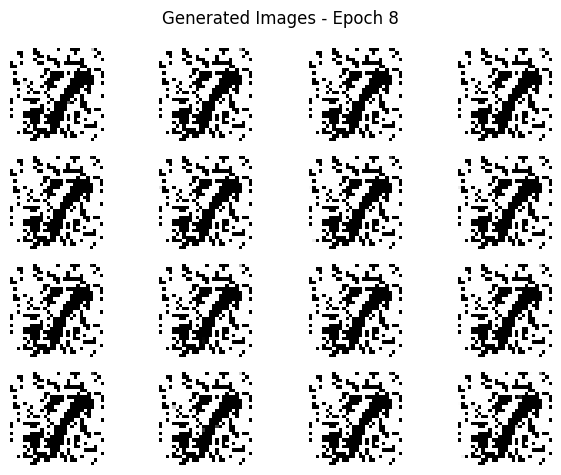

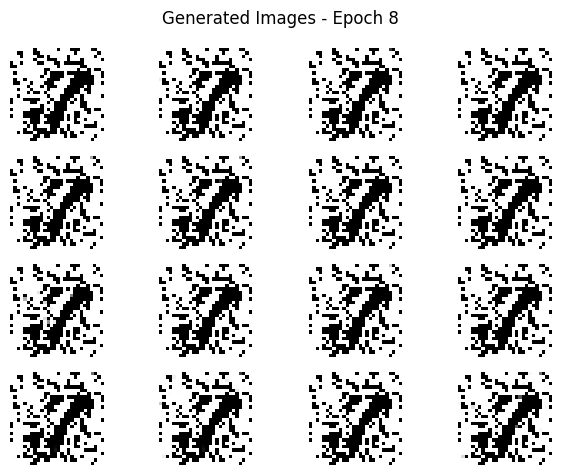

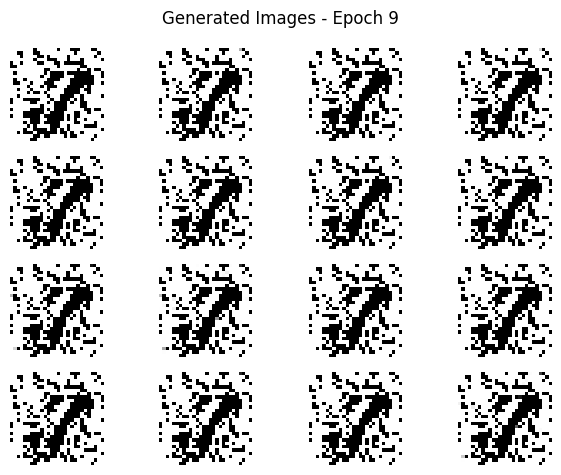

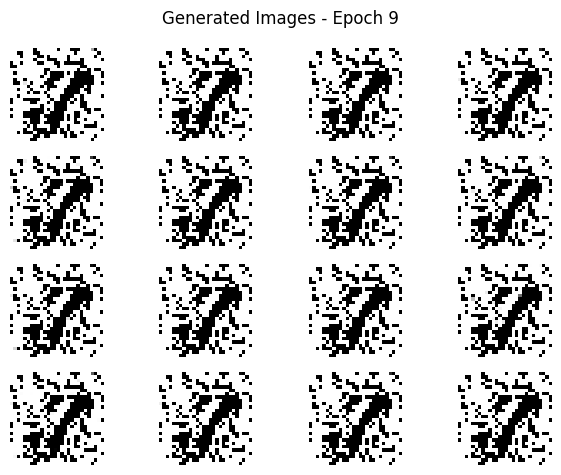

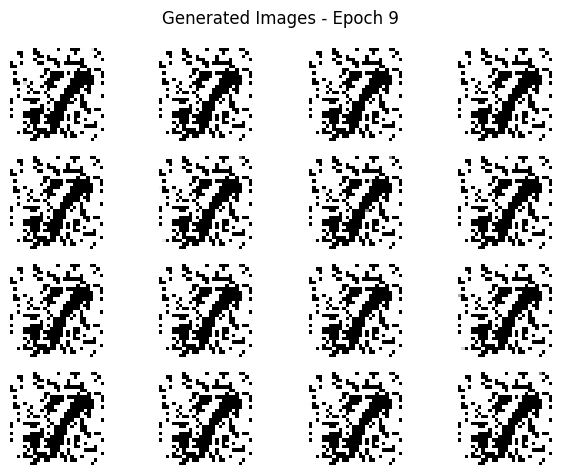

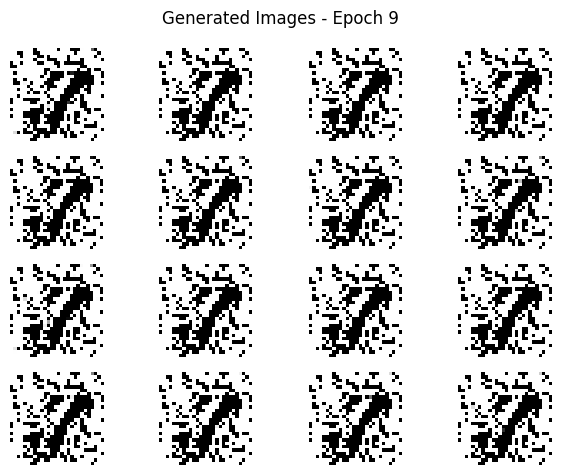

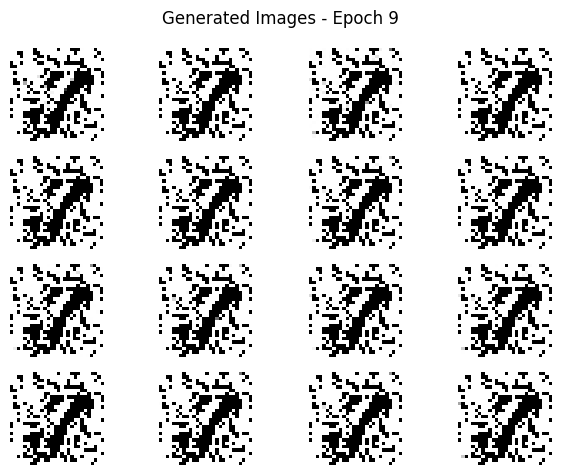

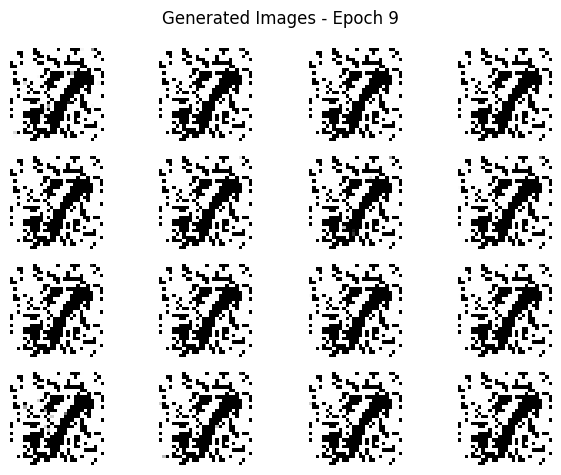

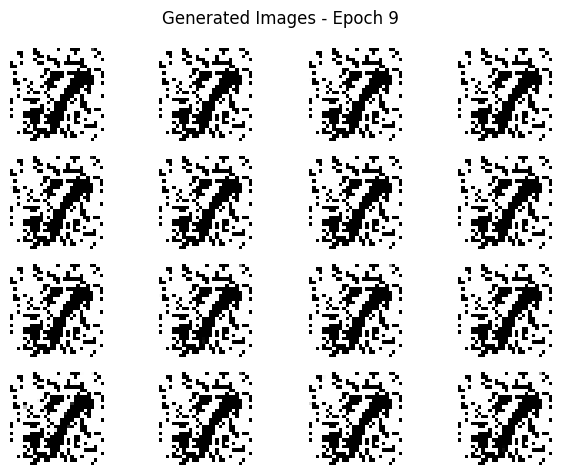

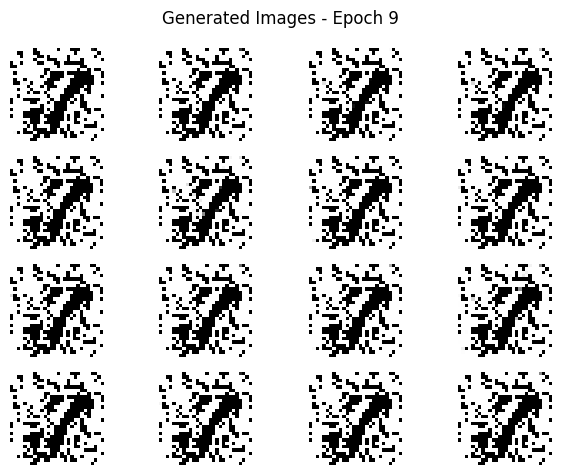

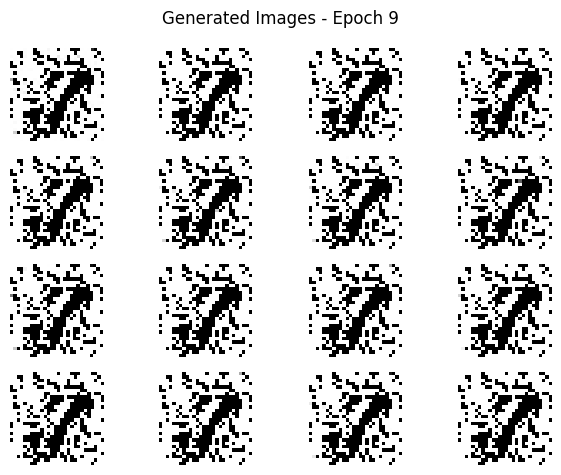

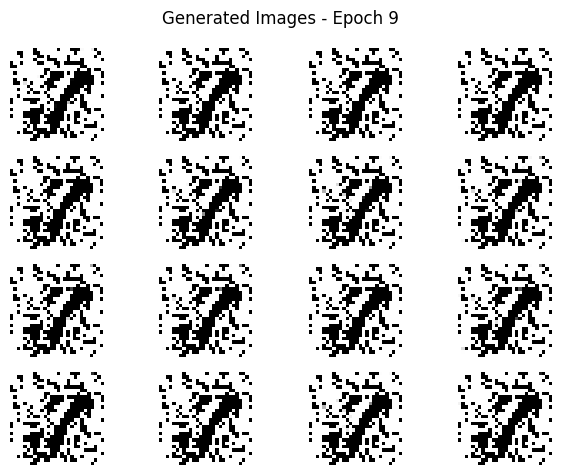

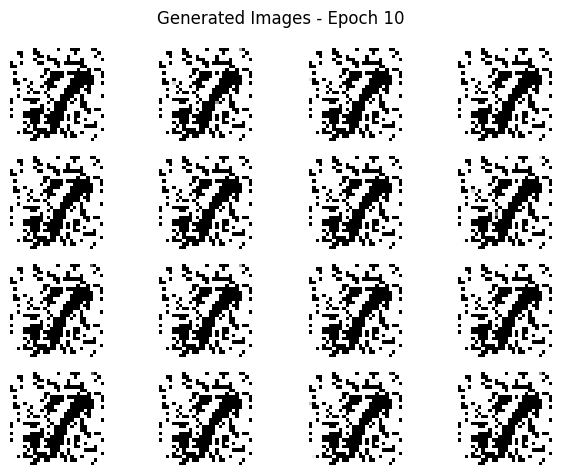

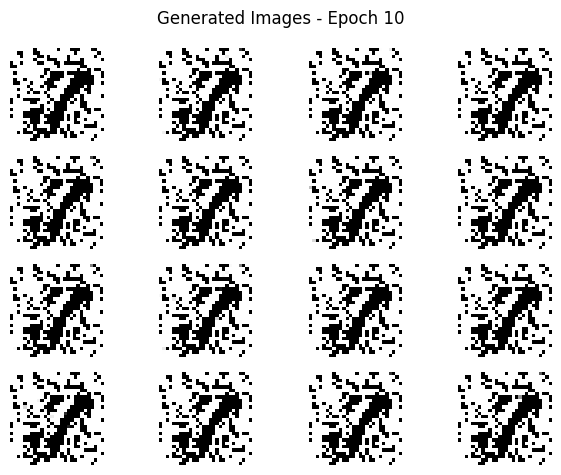

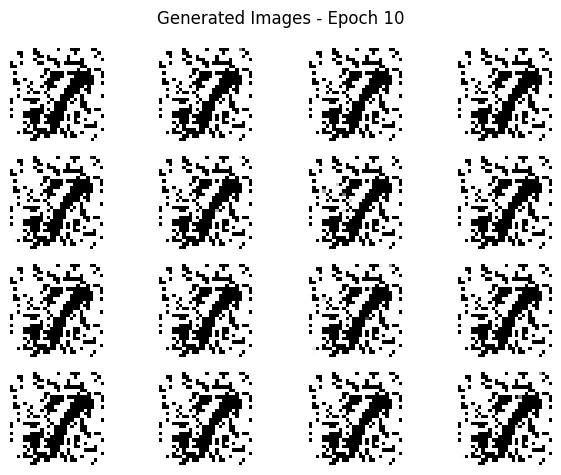

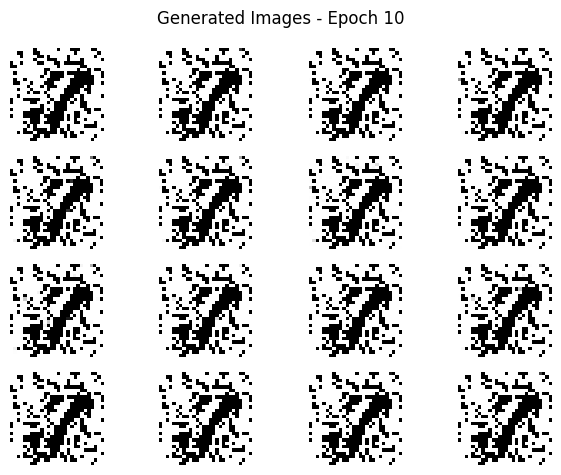

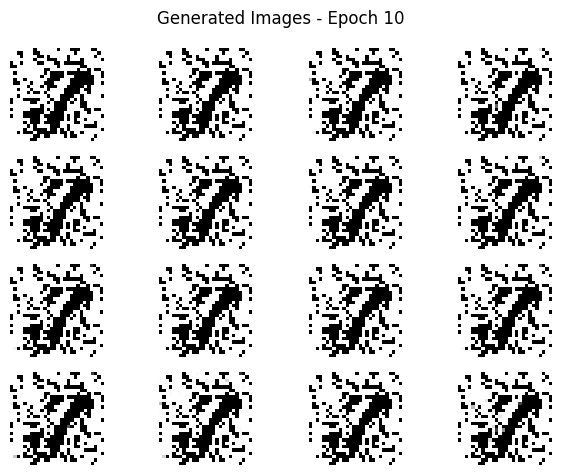

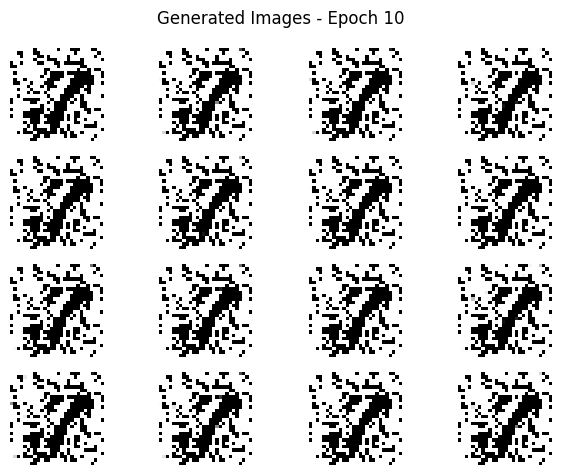

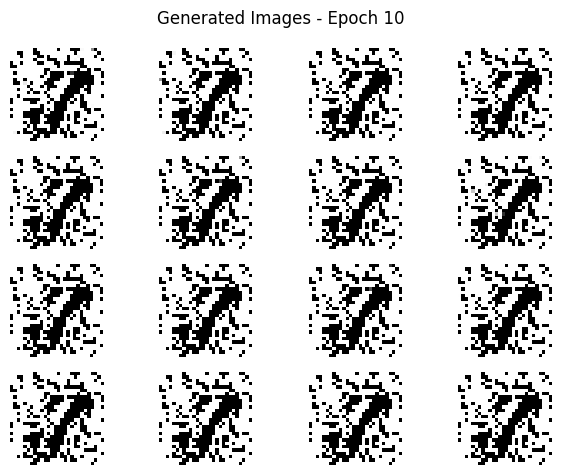

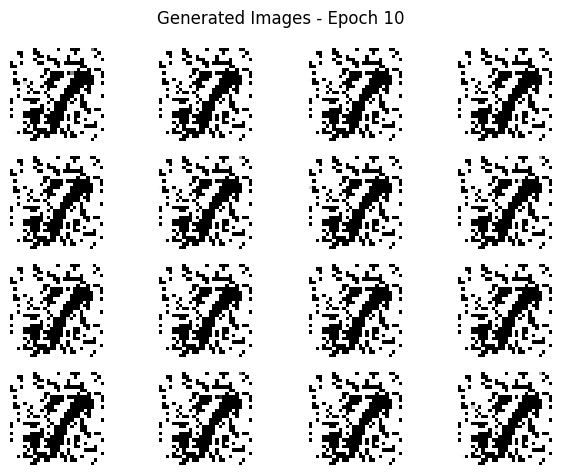

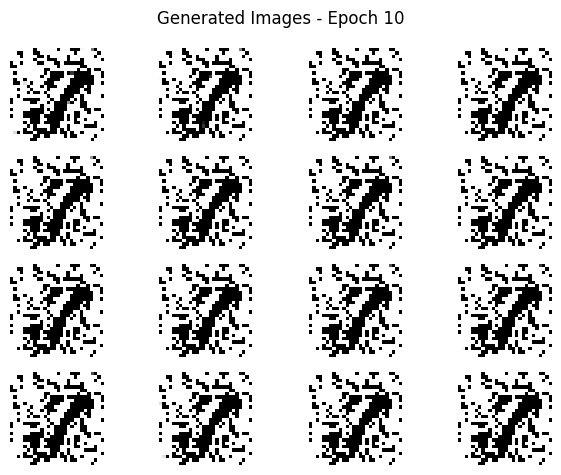

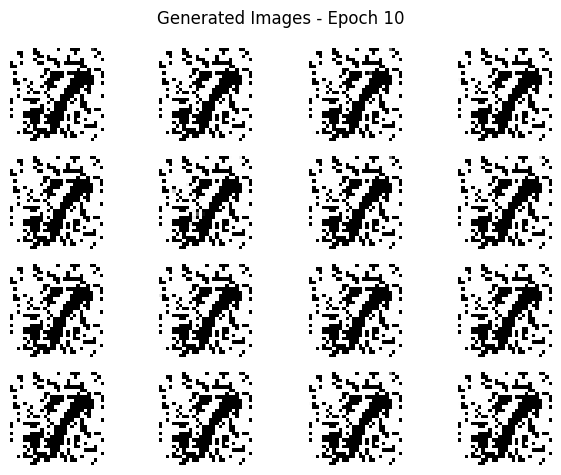

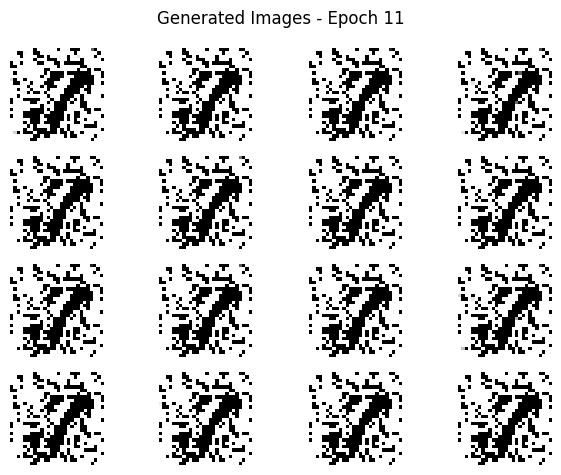

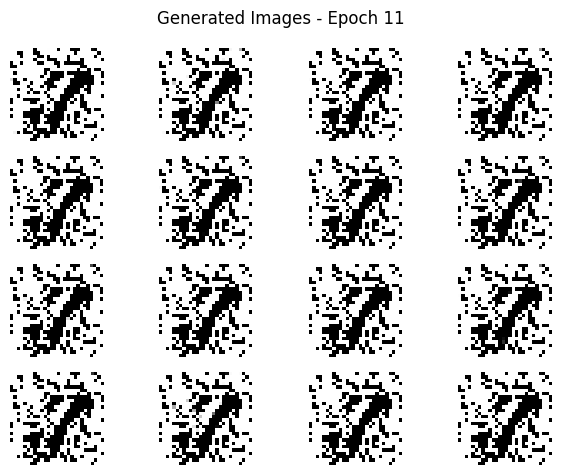

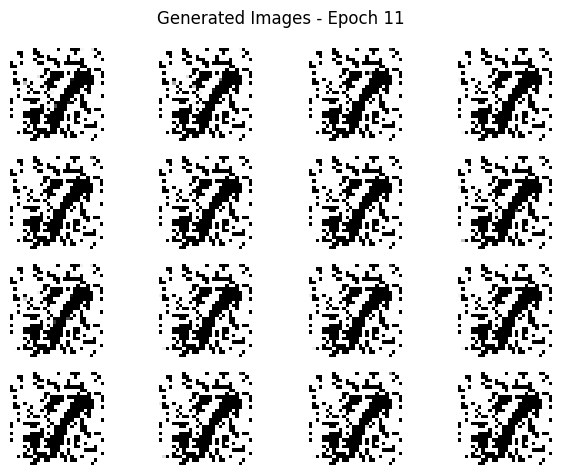

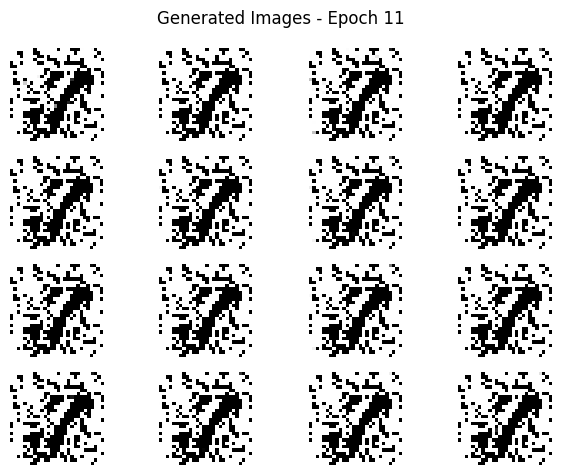

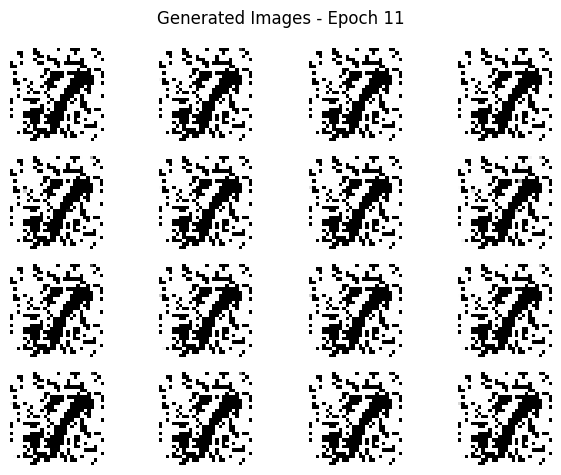

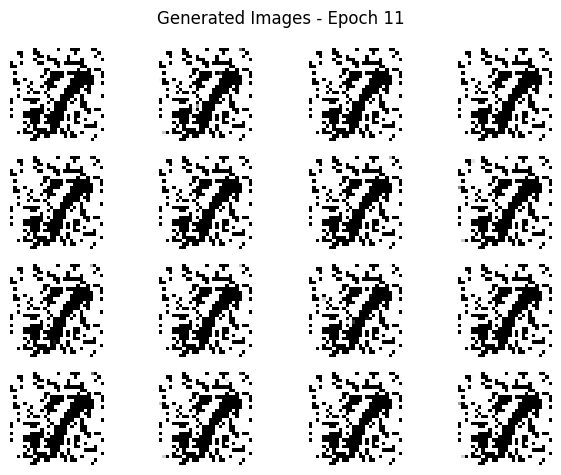

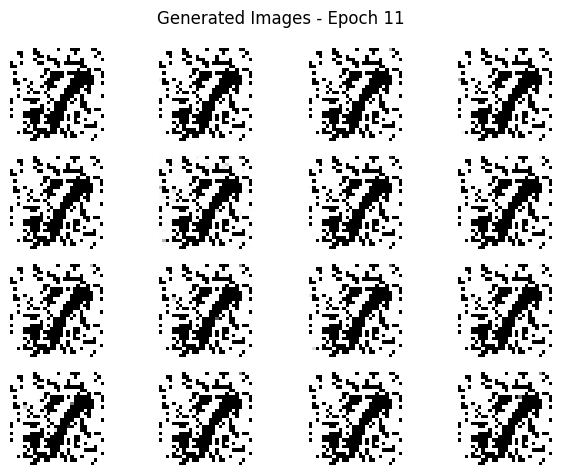

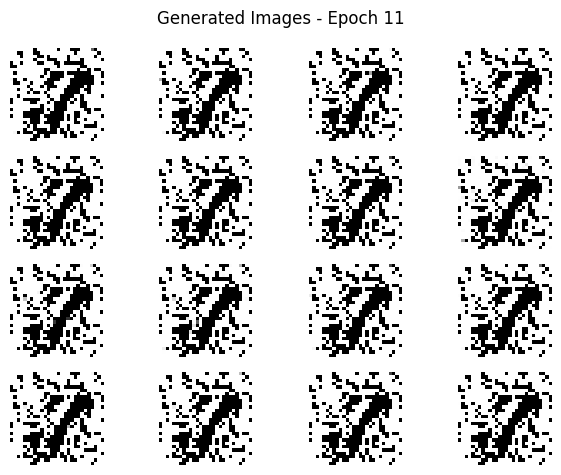

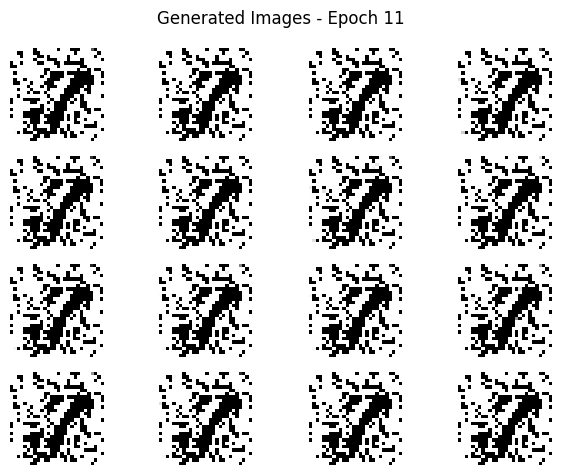

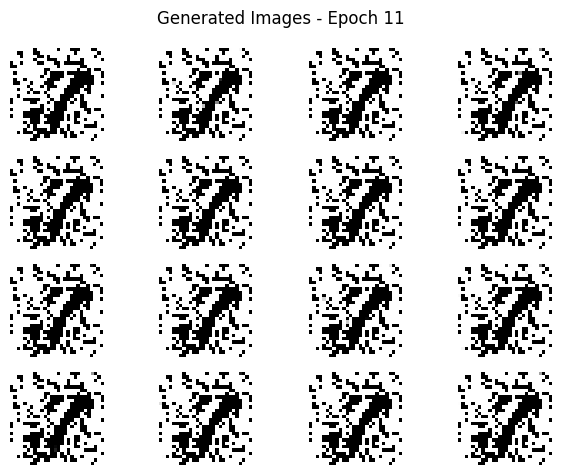

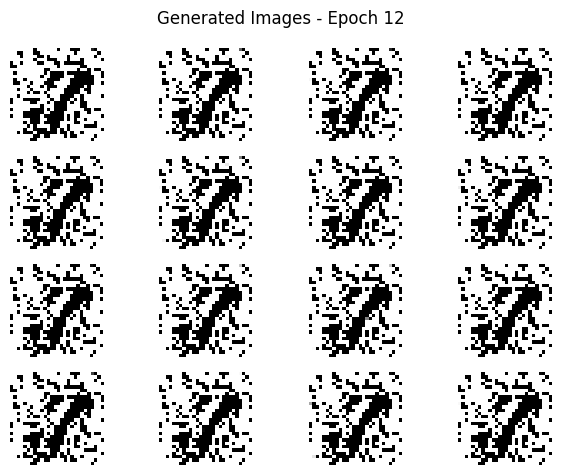

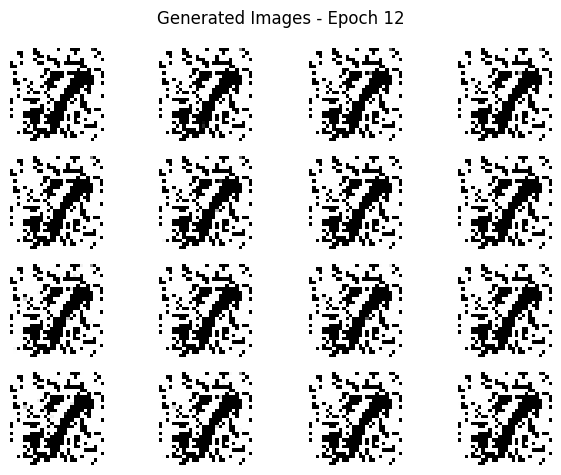

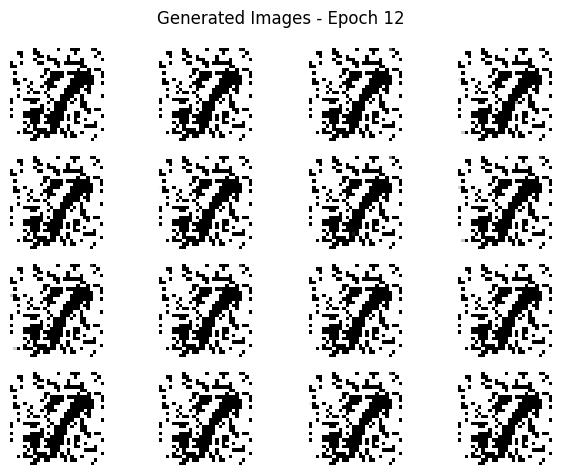

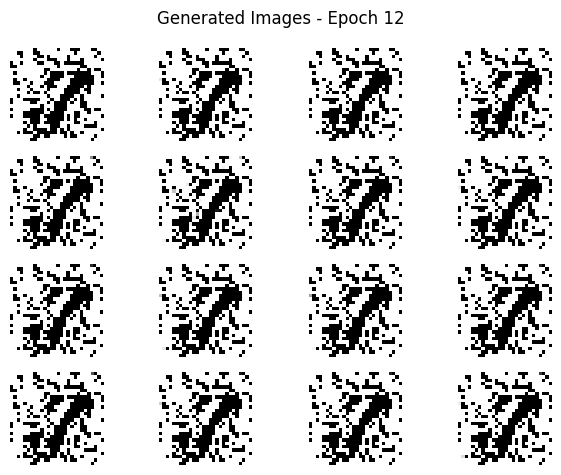

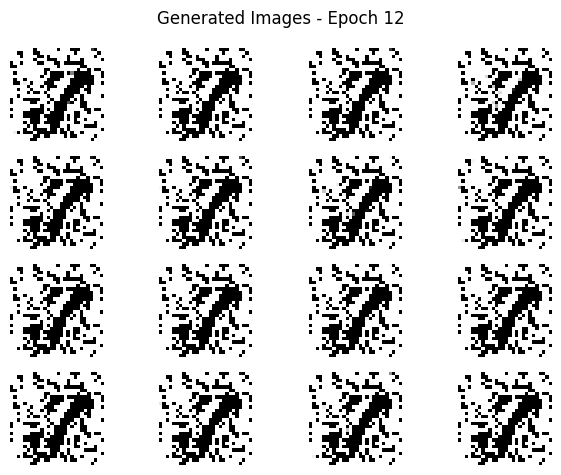

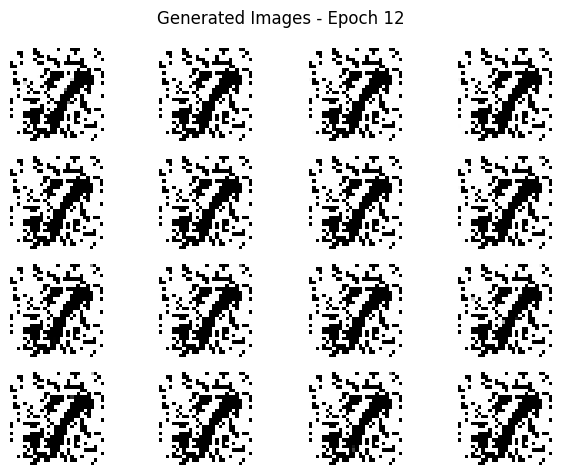

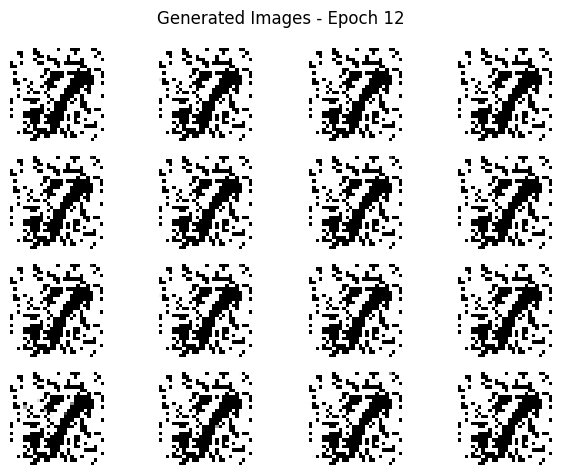

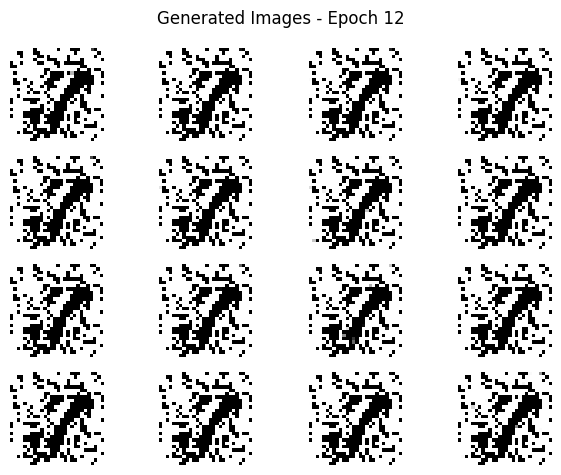

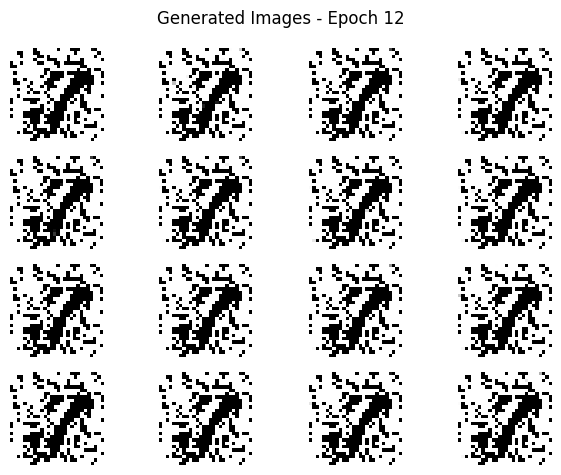

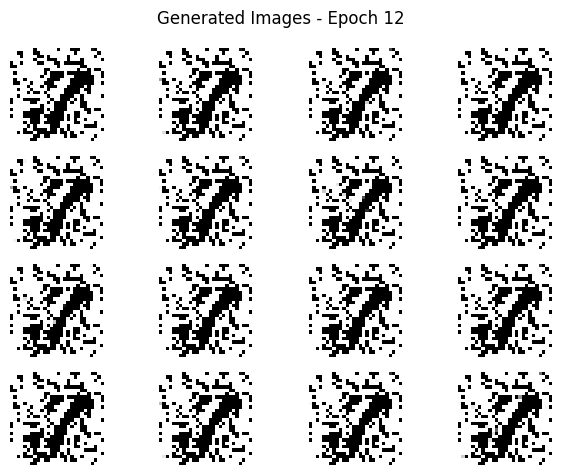

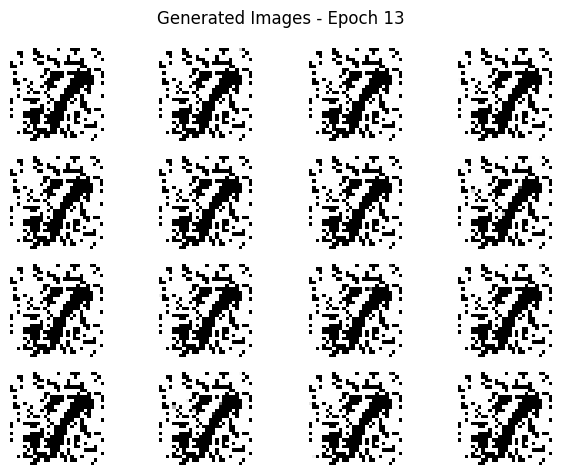

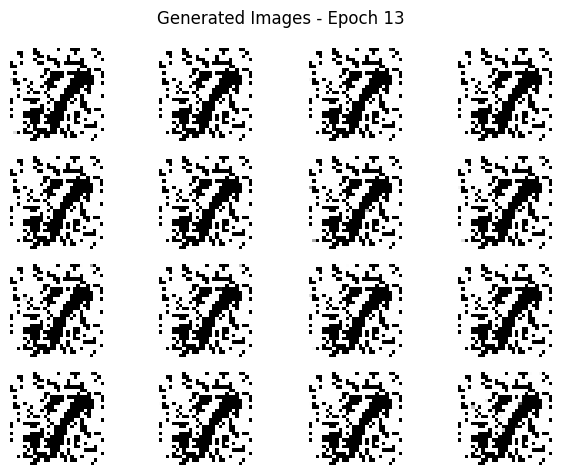

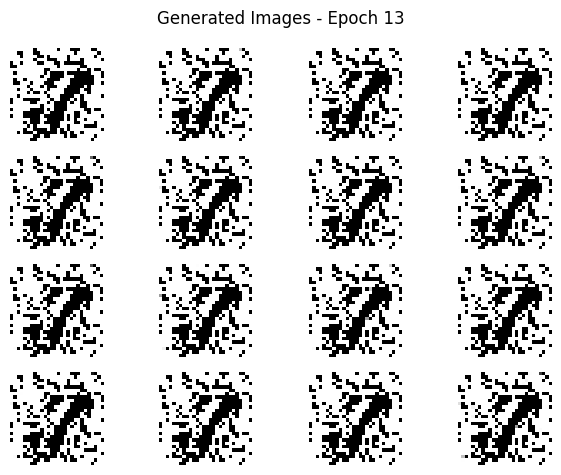

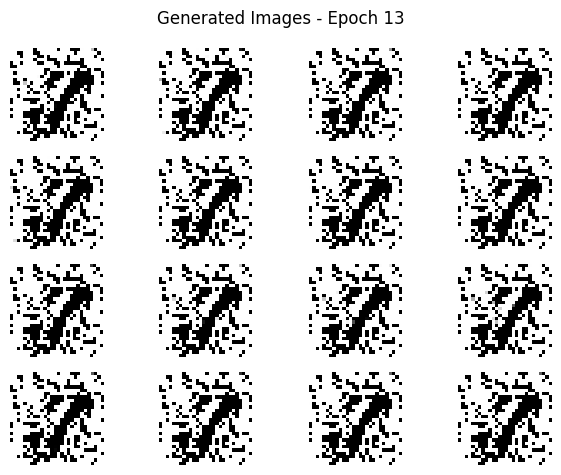

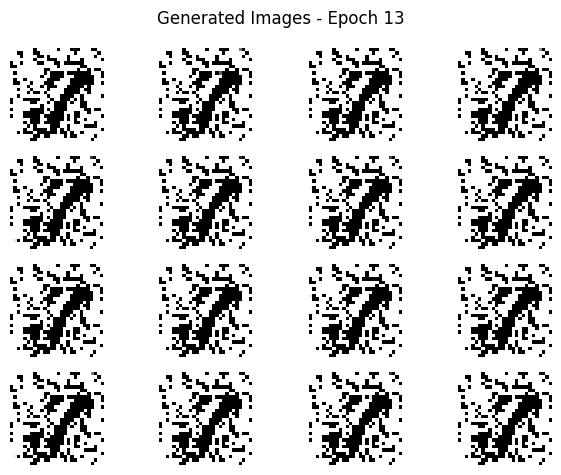

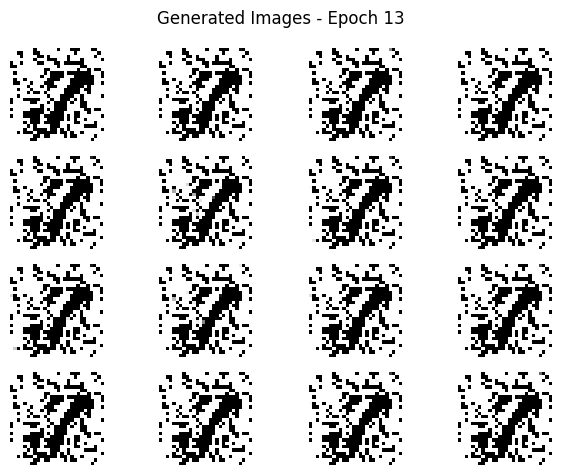

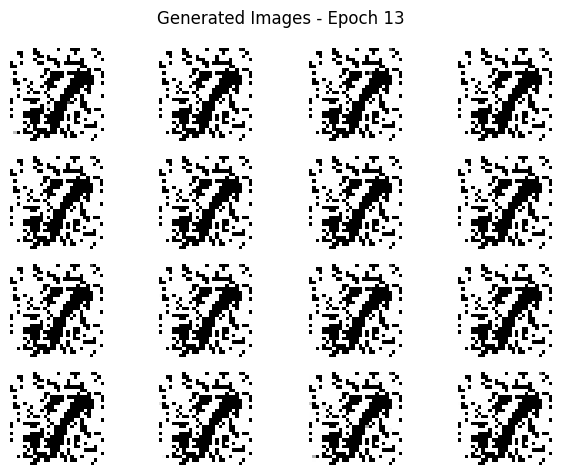

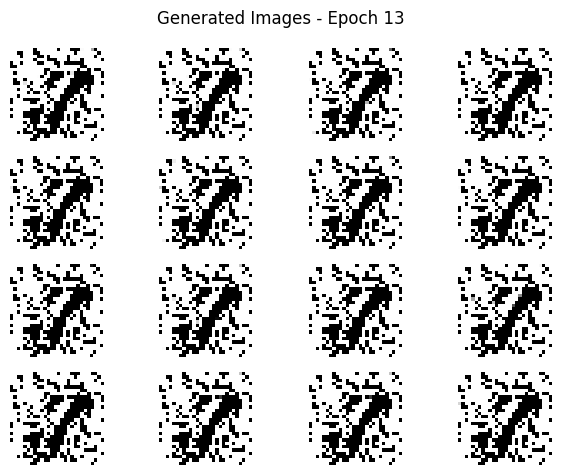

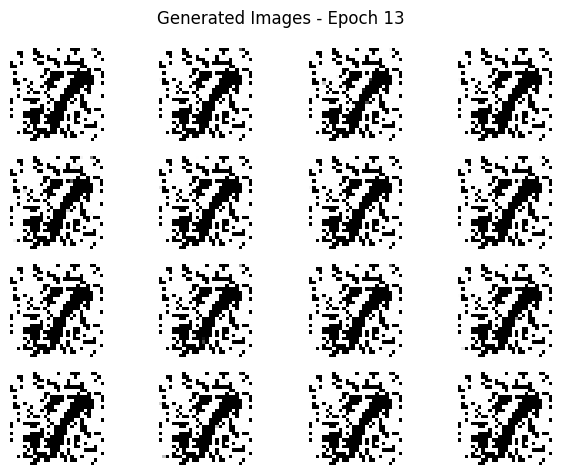

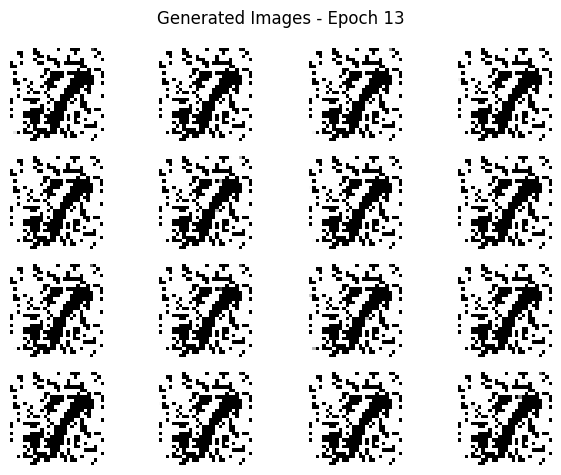

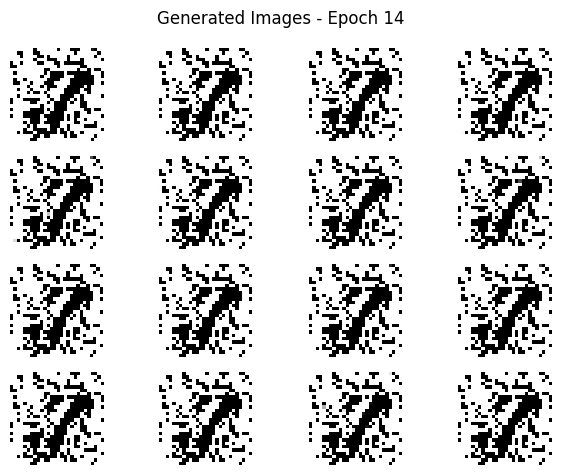

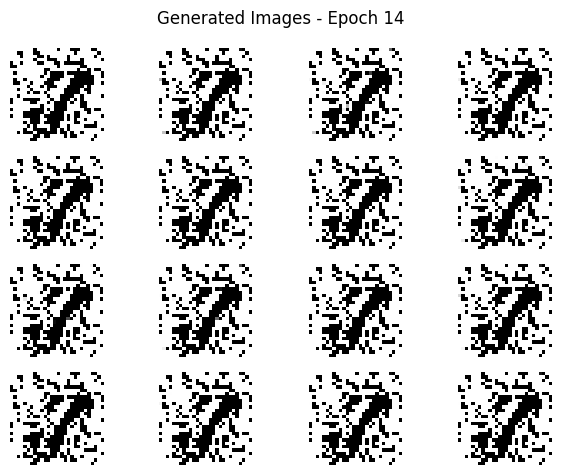

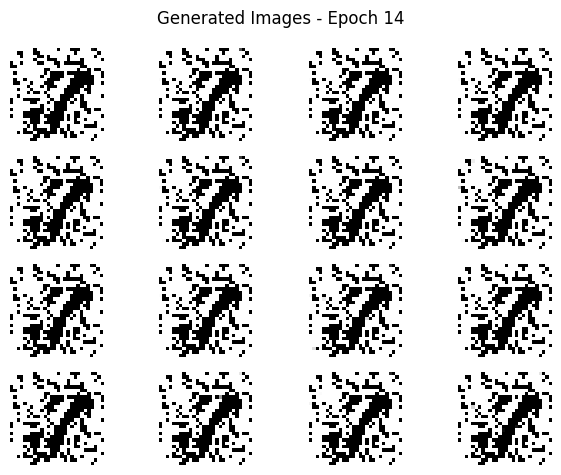

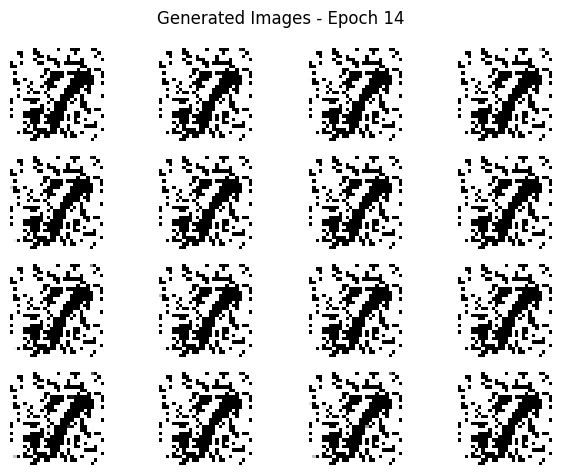

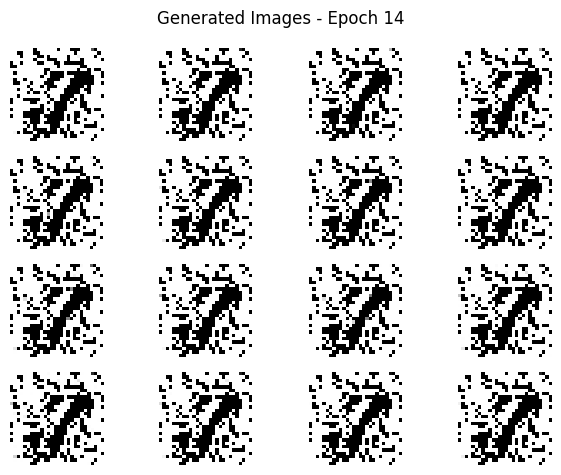

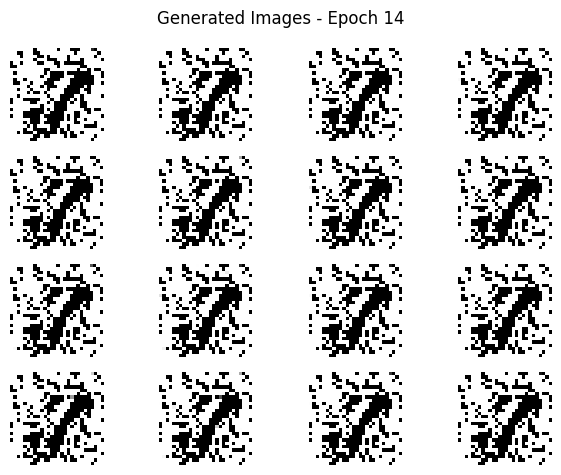

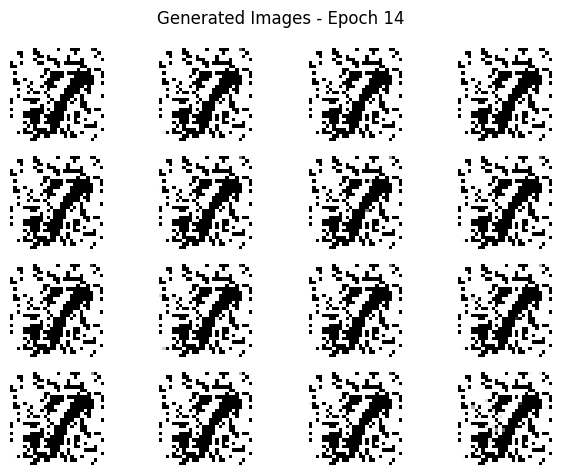

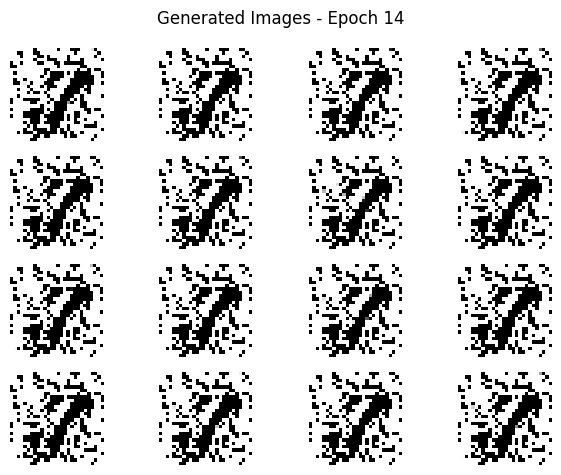

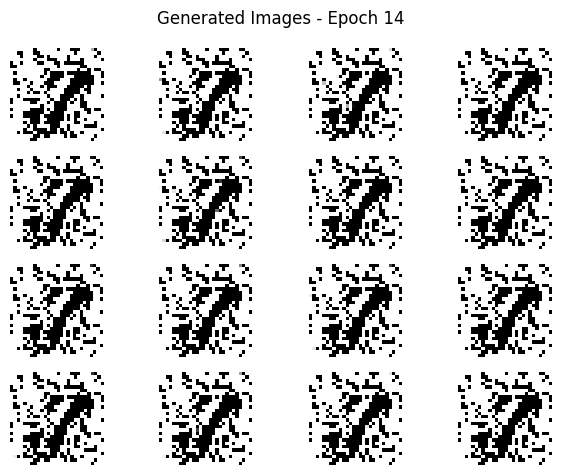

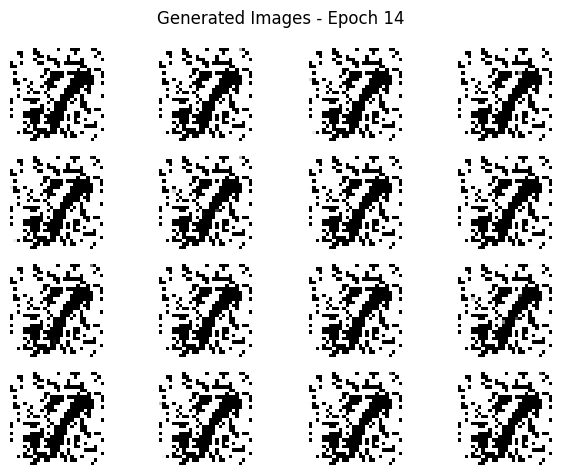

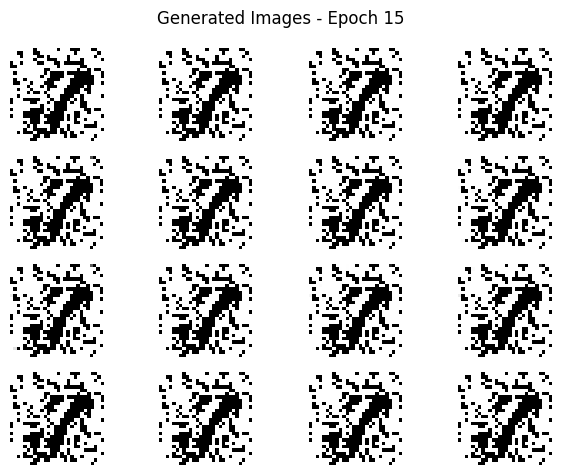

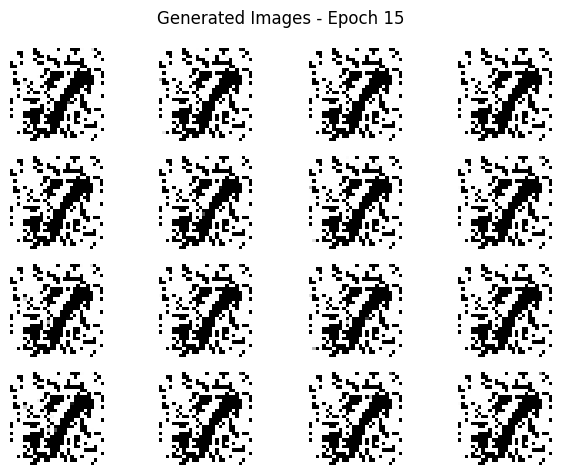

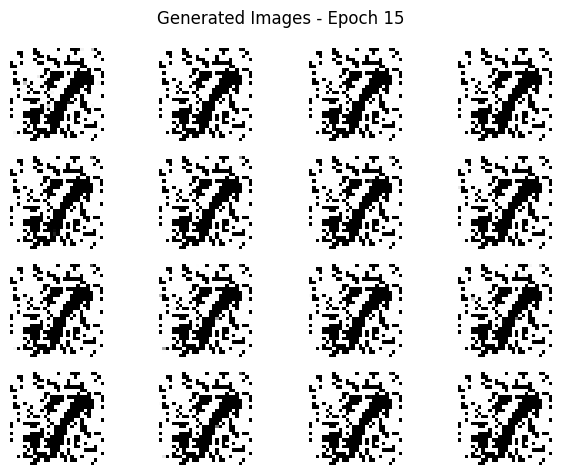

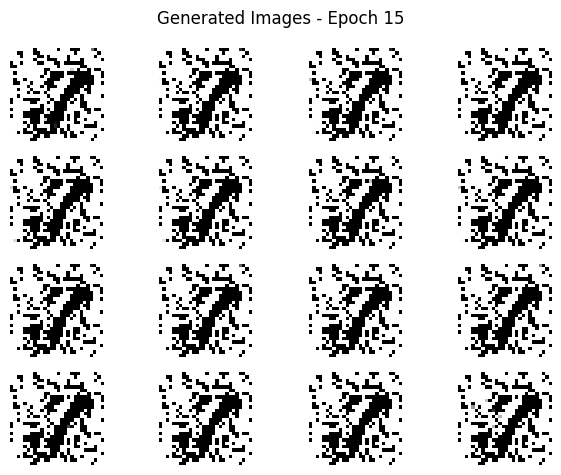

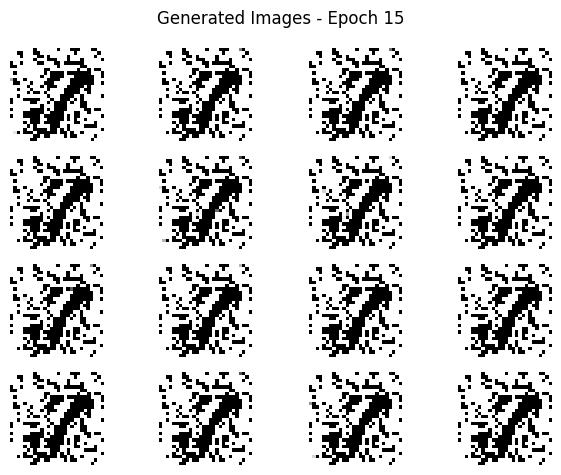

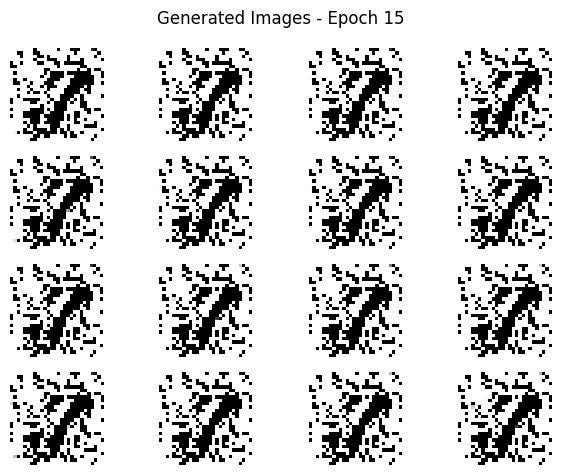

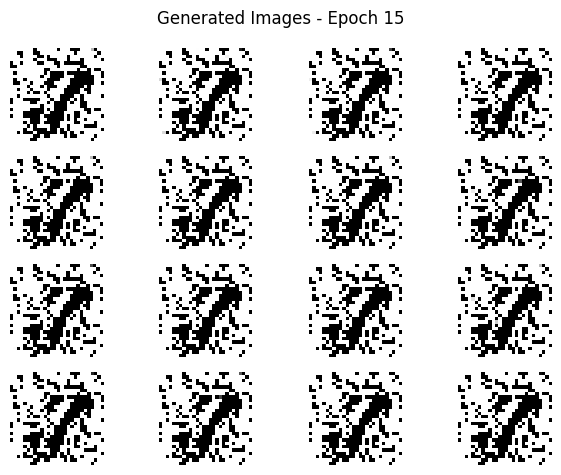

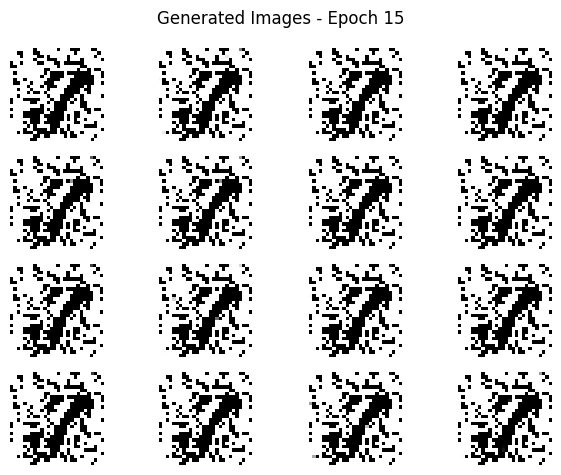

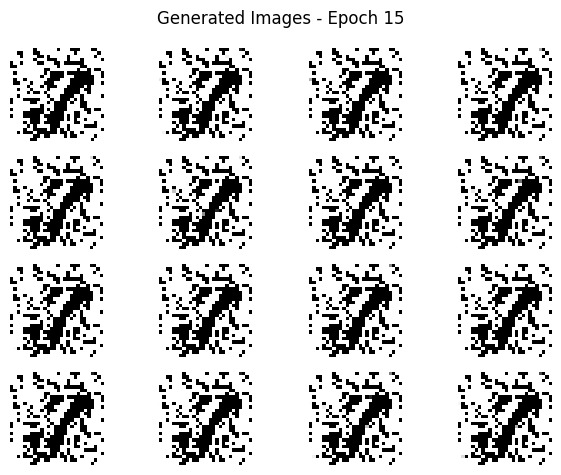

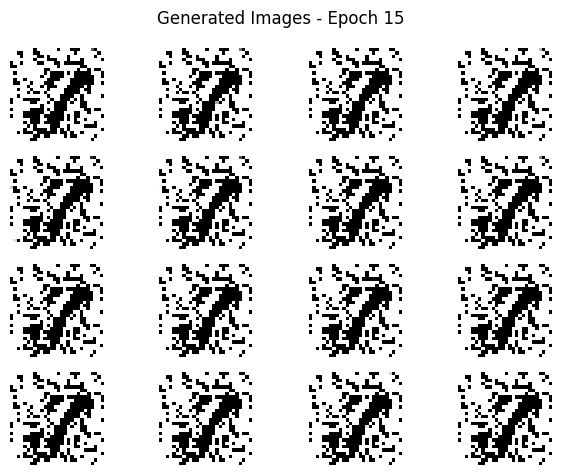

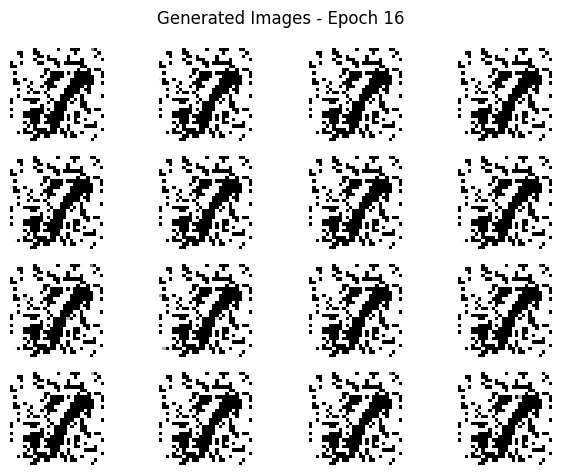

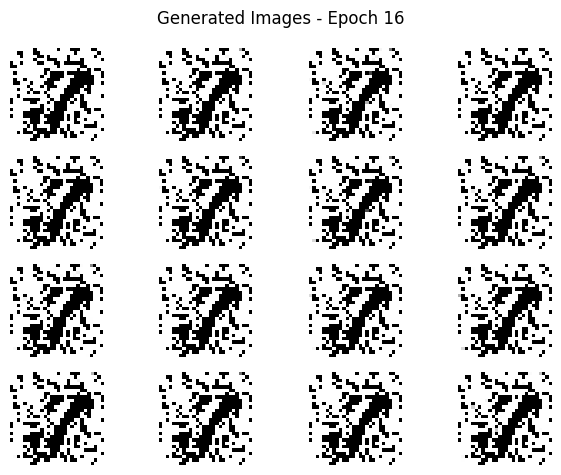

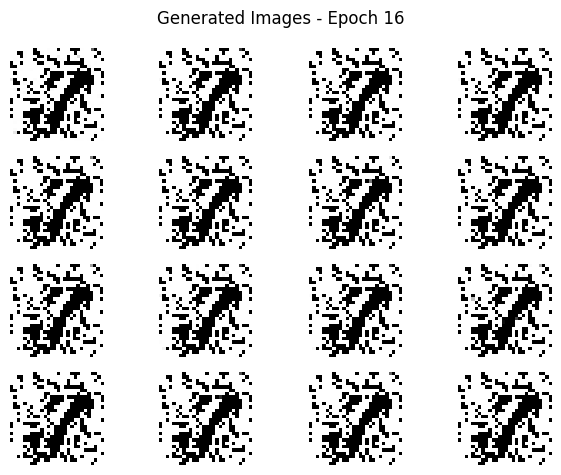

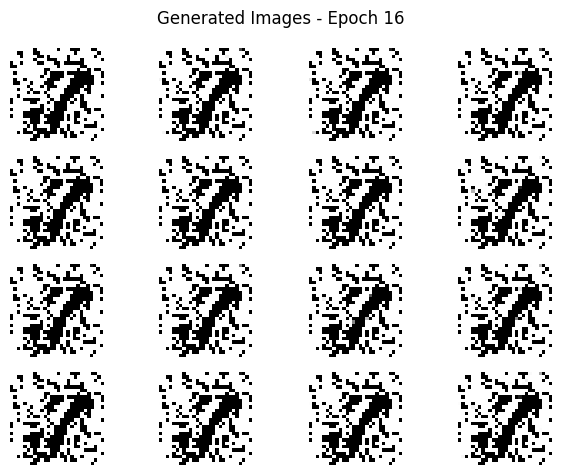

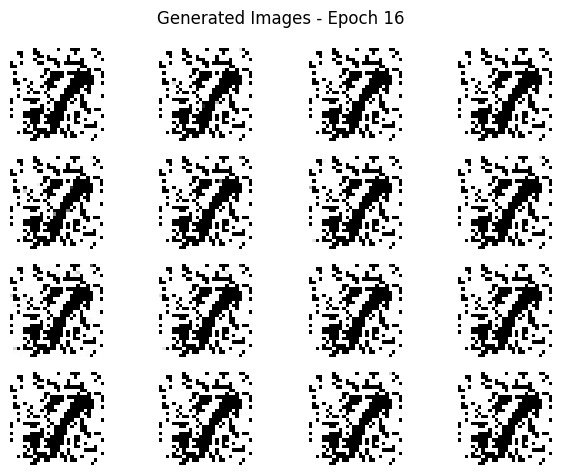

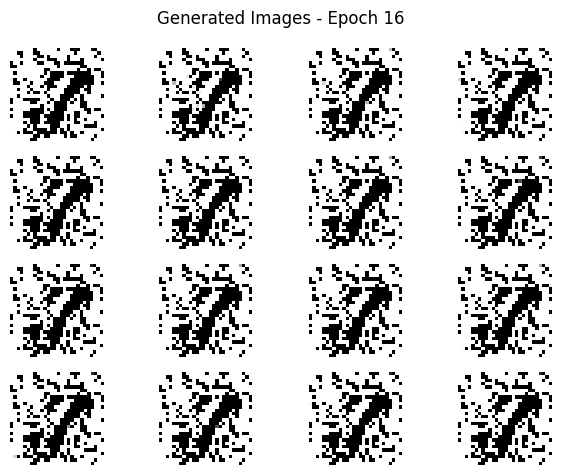

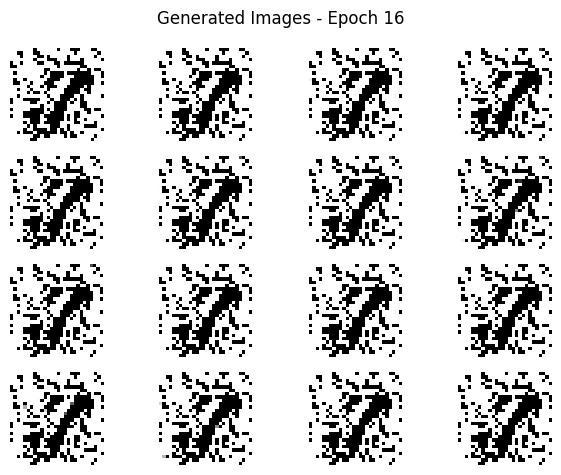

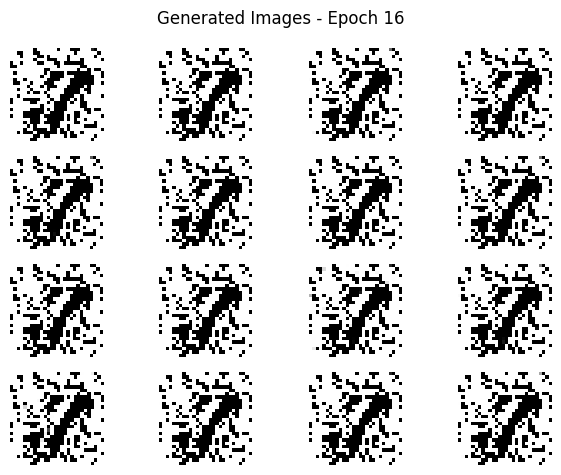

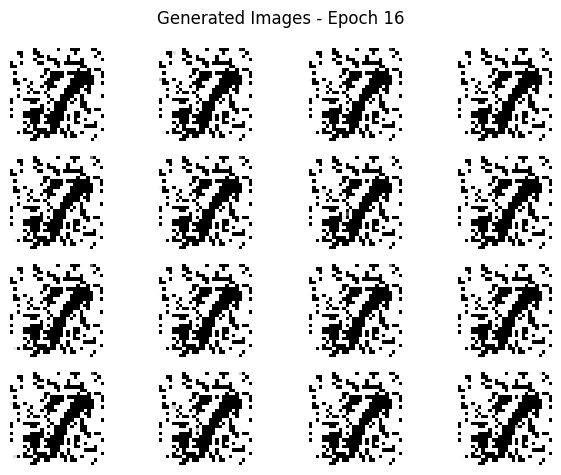

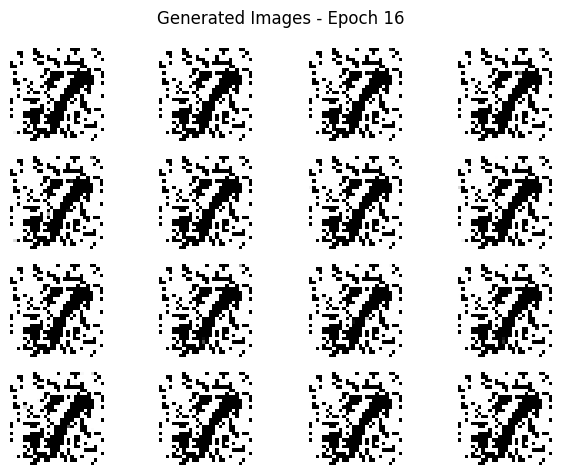

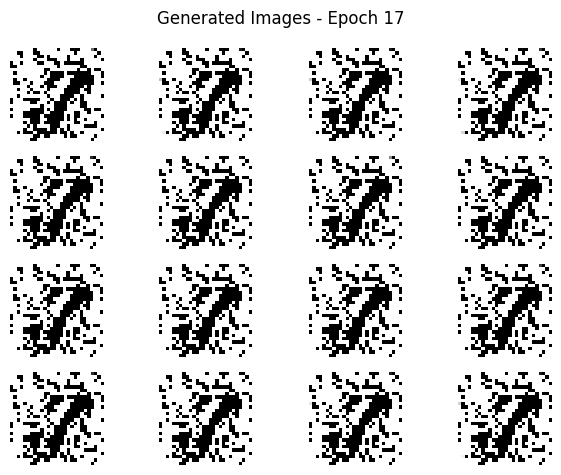

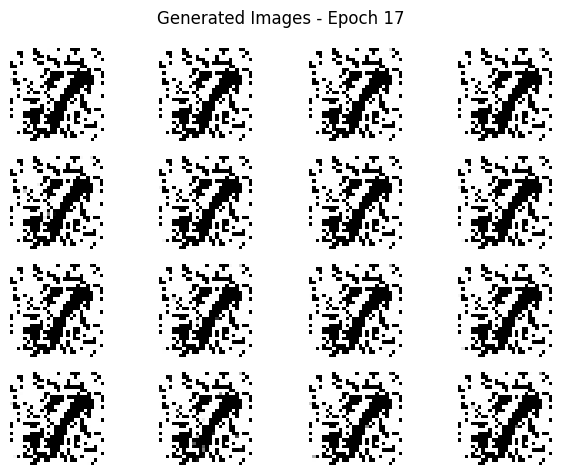

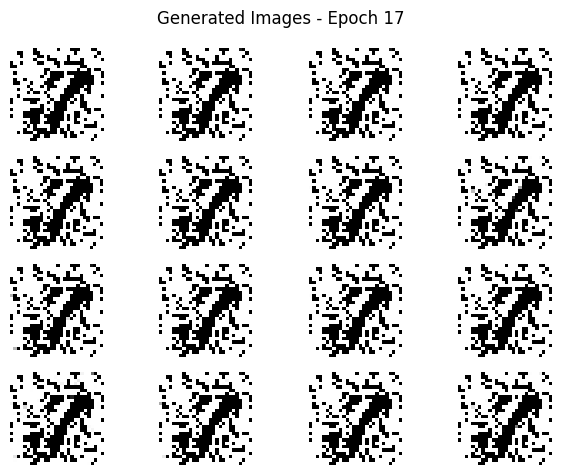

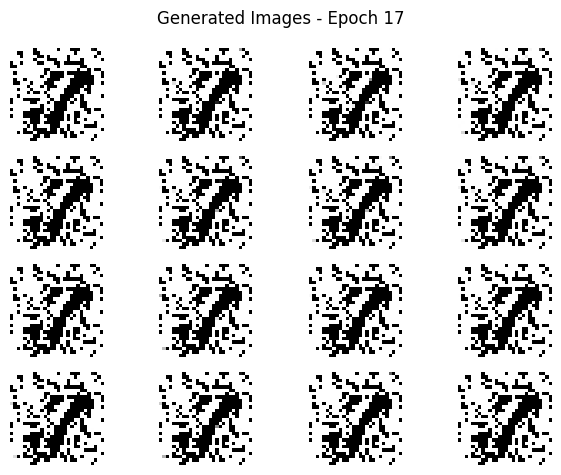

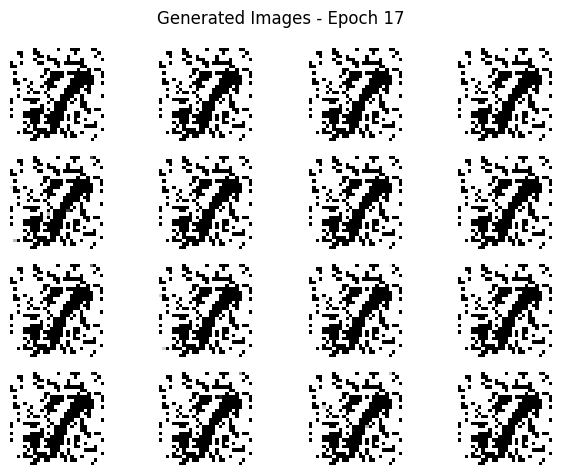

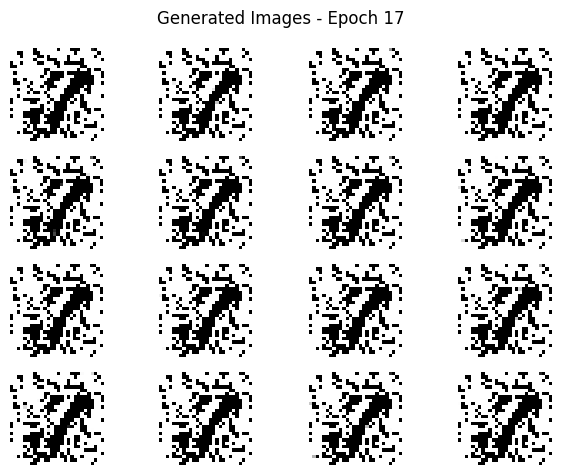

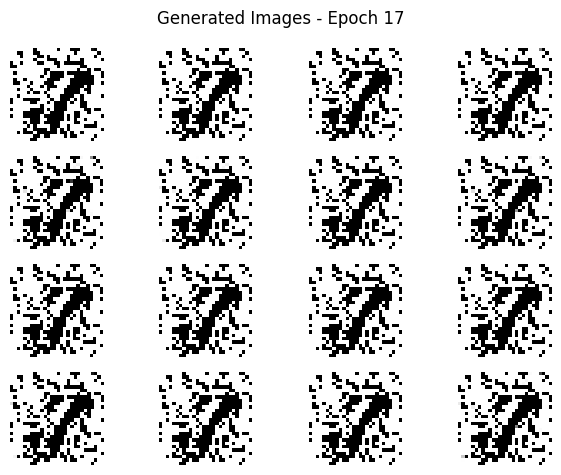

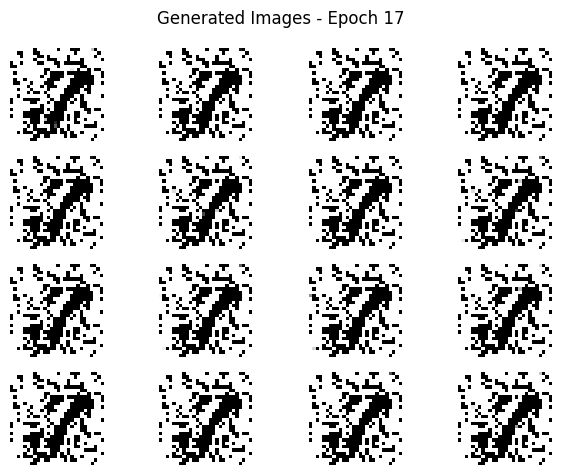

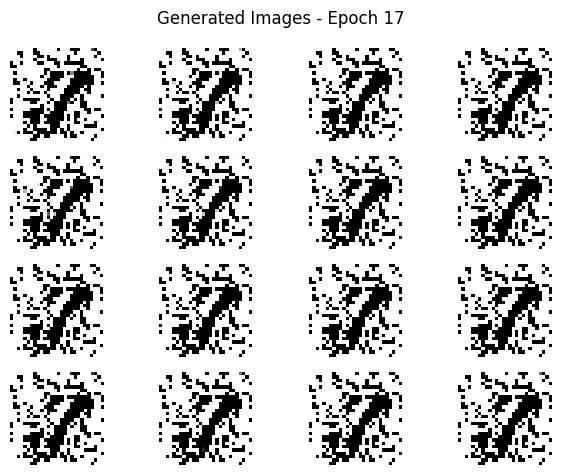

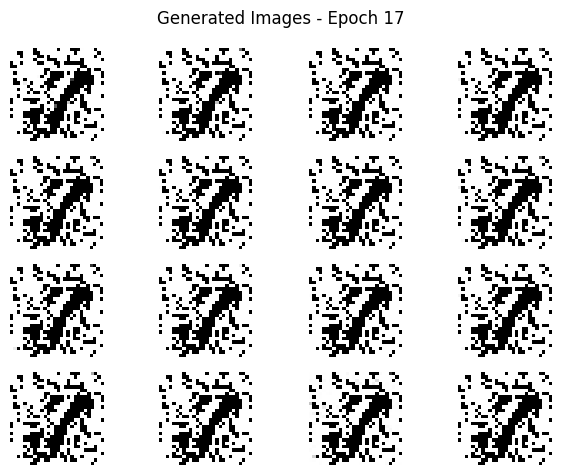

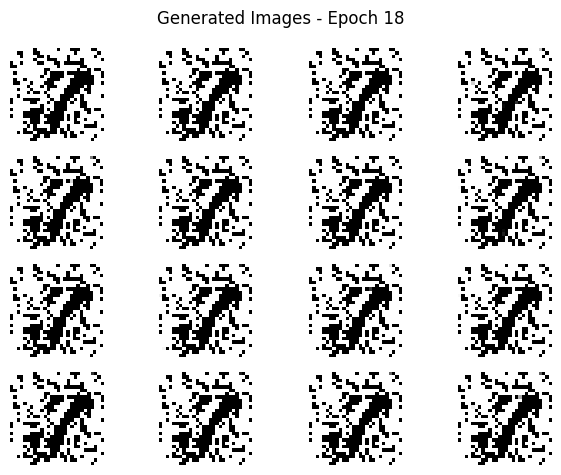

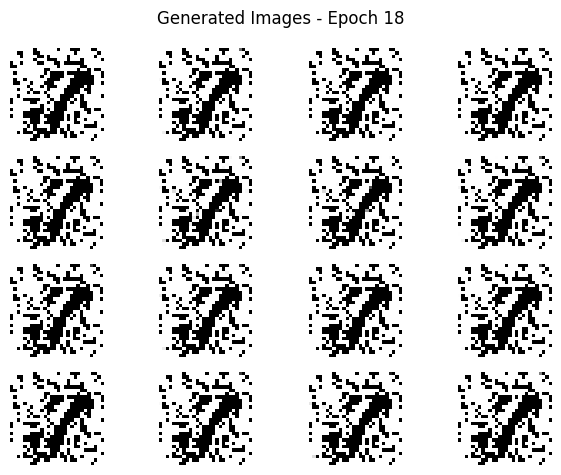

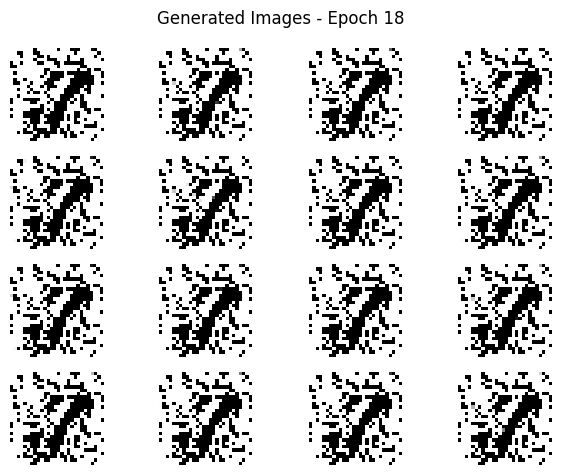

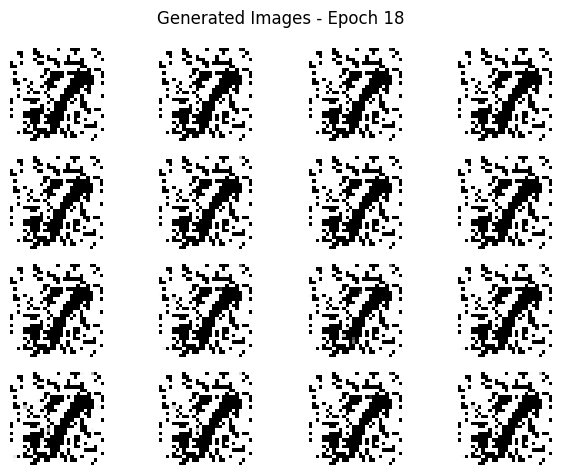

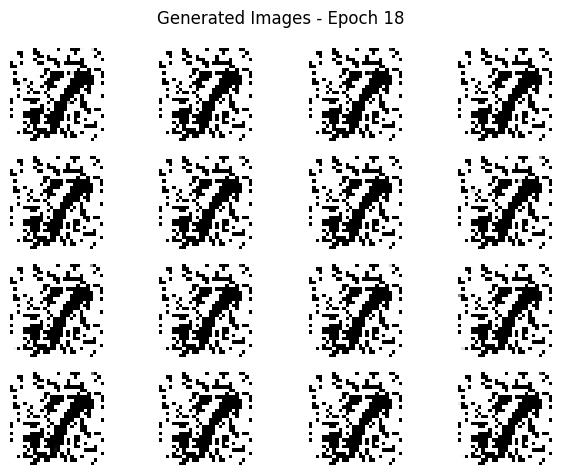

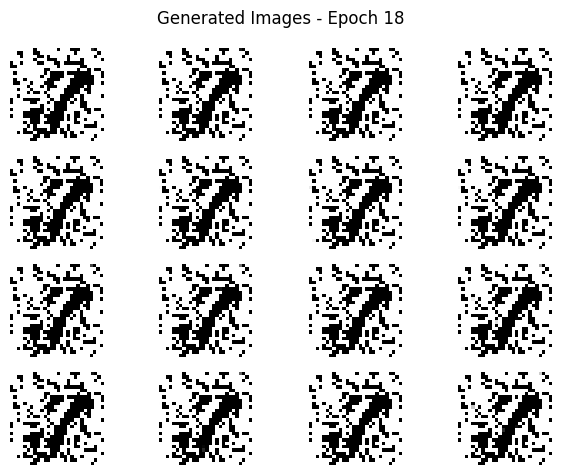

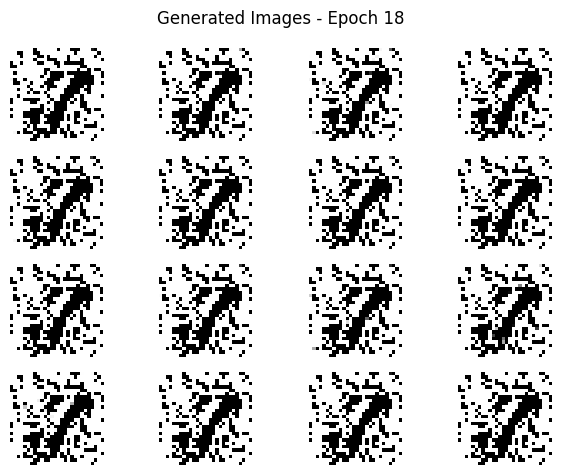

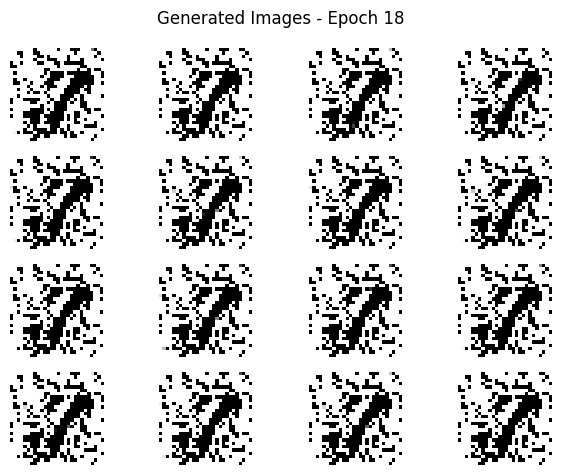

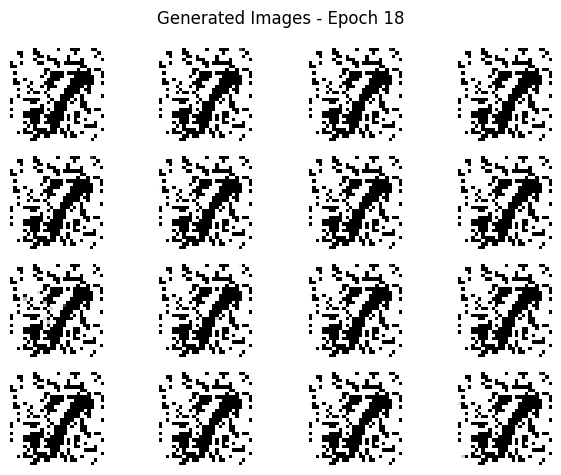

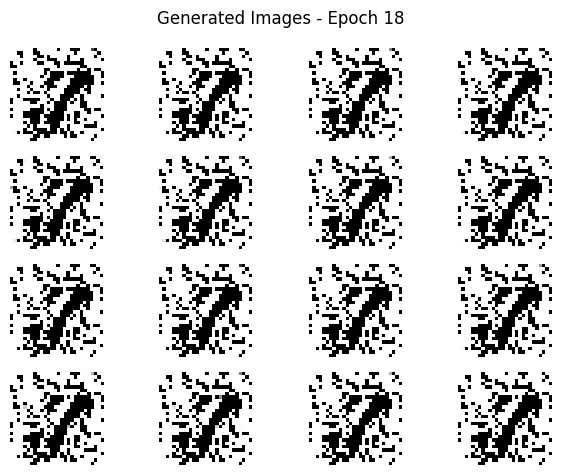

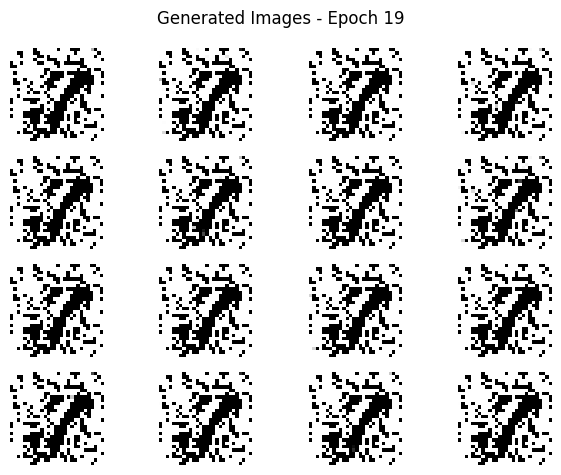

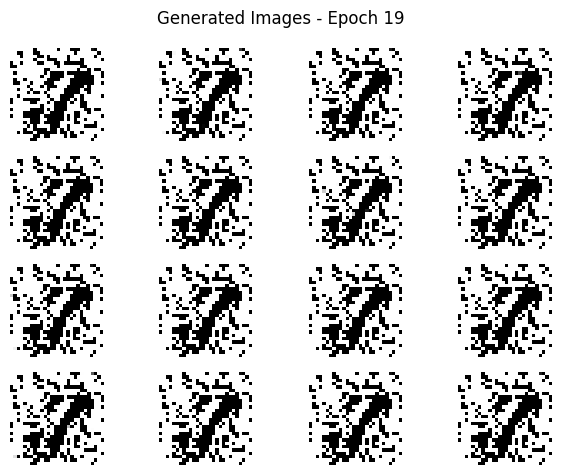

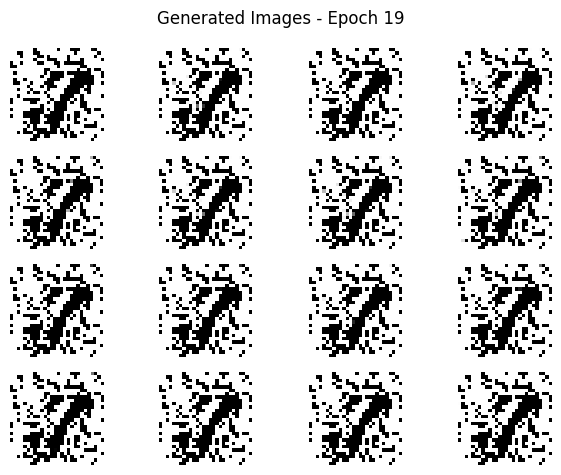

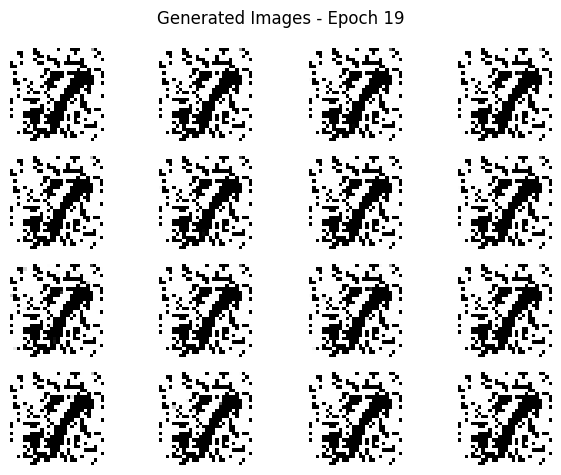

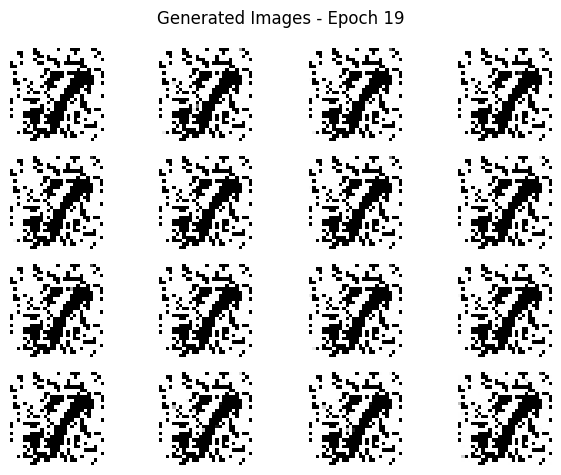

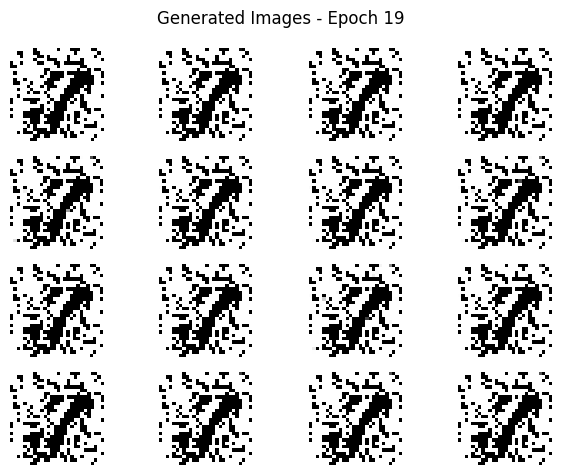

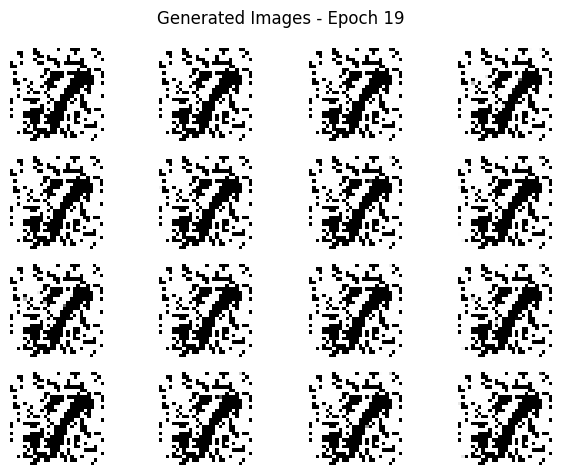

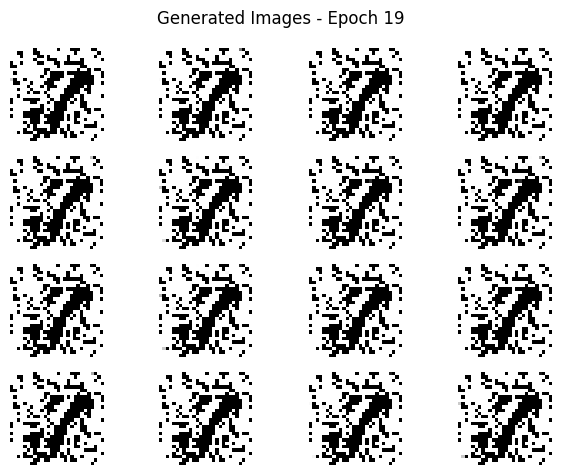

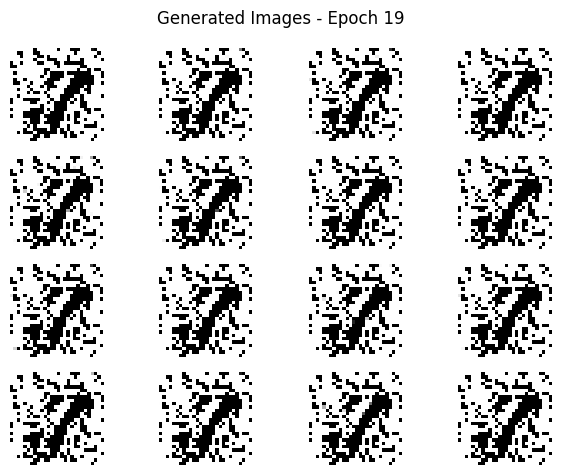

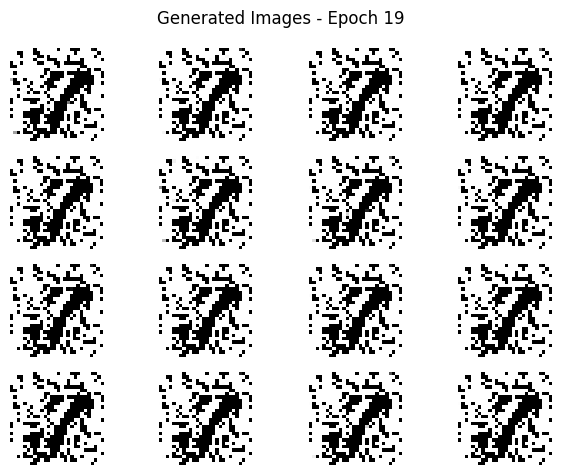

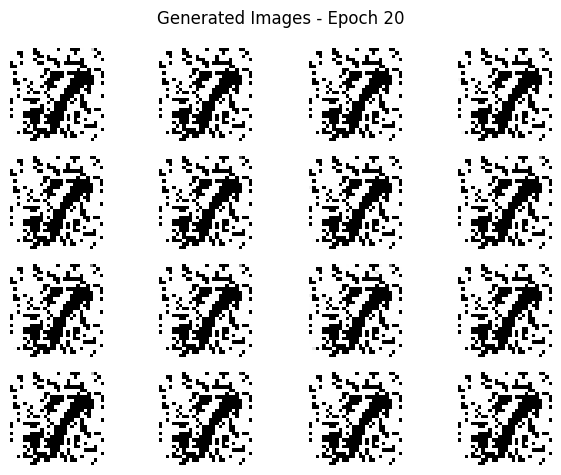

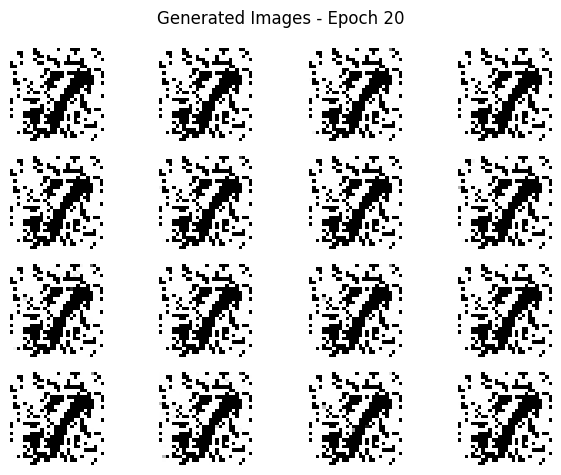

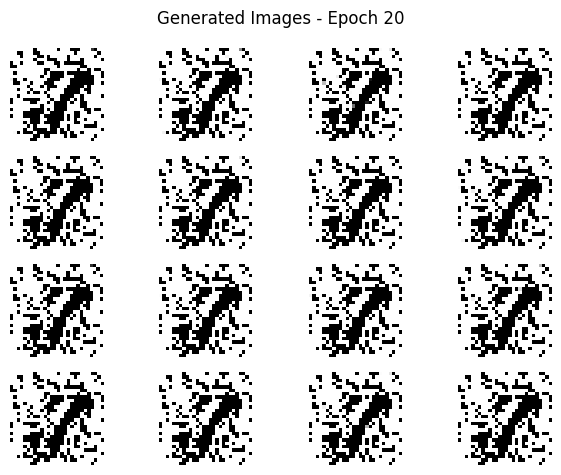

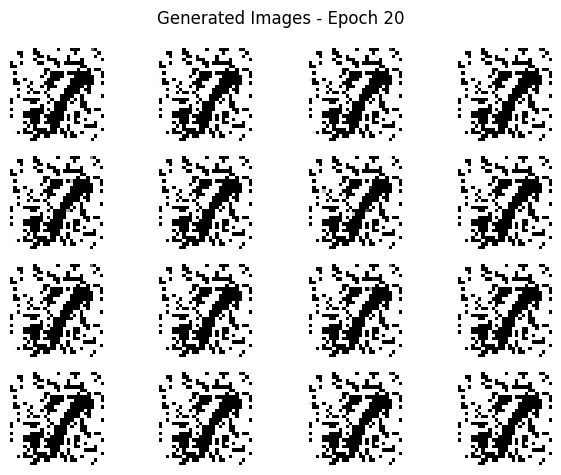

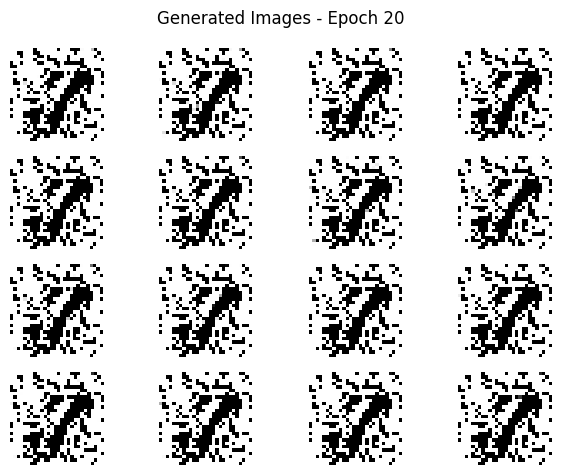

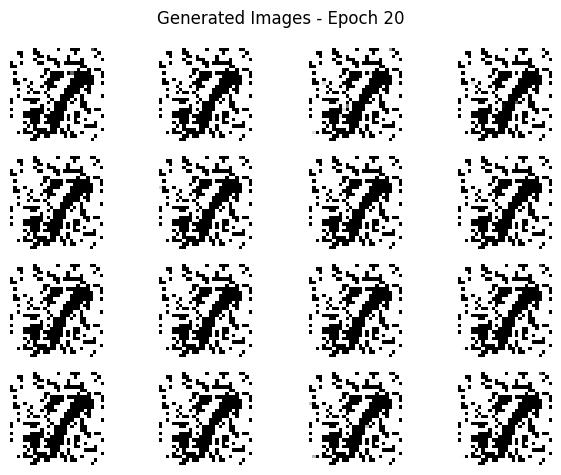

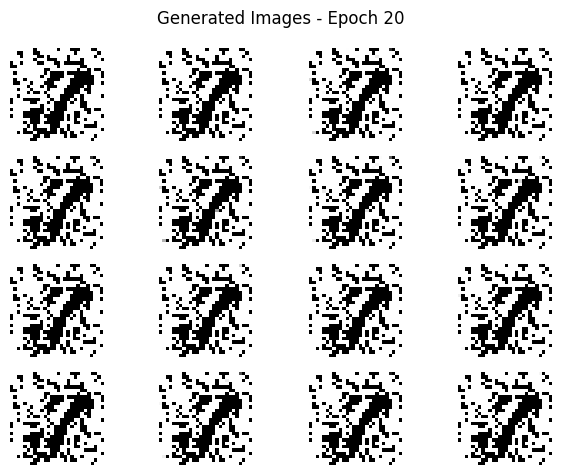

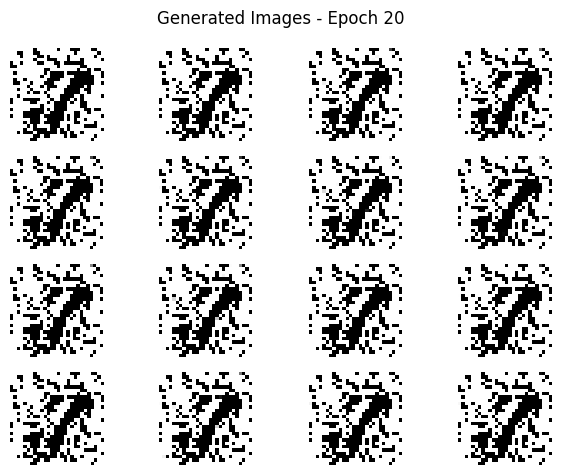

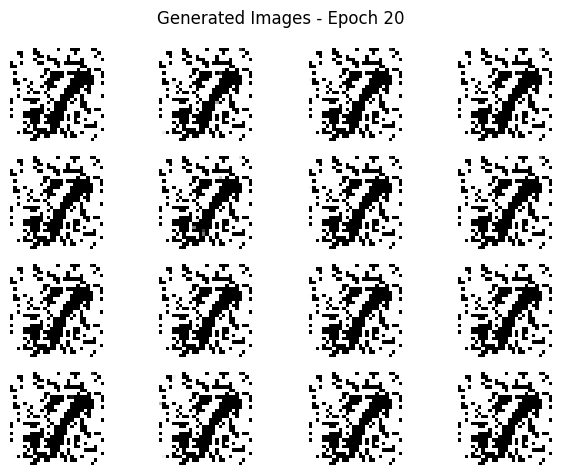

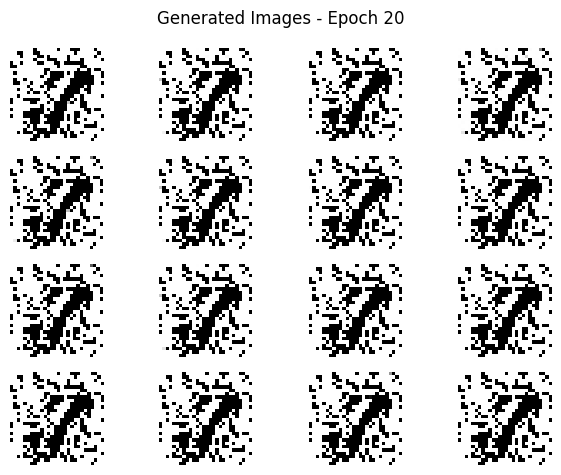

In [48]:
train_gan(batch_size=64, num_epochs=20)
